In [752]:
import matplotlib as mpl
import matplotlib.cm as cm
import os
import json
import glob
import copy
import copy
import itertools
import cv2
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from pipeline.python.retinotopy import convert_coords as coords

from pipeline.python.classifications import experiment_classes as util
#from pipeline.python.classifications import retino_structure as ret
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import rf_utils as rfutils
# from pipeline.python.utils import natural_keys, label_figure, convert_range, add_meta_to_df
from pipeline.python import utils as putils

from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse

In [753]:
%matplotlib notebook

In [754]:
#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

#### Preprocessing params
responsive_test = None
responsive_thr = None
n_stds = None

#### RF fit params
response_type = 'dff'
fit_thr=0.5


# Set plot params

In [755]:
putils.set_plot_params(color='k')
dpi = 150
visual_areas, area_colors = putils.set_threecolor_palette()
area_colors

{'Li': 'dodgerblue', 'Lm': 'orange', 'V1': 'magenta'}

# Output dir

In [759]:
#### Set outputdir for current analysis
do_spherical_correction=True
rf_type = 'sphr' if do_spherical_correction else ''

fit_desc = fitrf.get_fit_desc(response_type=response_type, do_spherical_correction=do_spherical_correction)
outdir = os.path.join(aggregate_dir, 'receptive-fields', '%s__%s' % (traceid, fit_desc))
if not os.path.exists(outdir):
    os.makedirs(outdir)
print("... saving output to base dir:\n%s" % outdir)

#### Create data ID for labeling figures with data-types
data_id = '|'.join([traceid, '%s-thr-%.2f' % (fit_desc, fit_thr)])

#### Filter RF datasets (no repeats)
filter_by = 'drop_repeats'
data_id = '%s|%s' % (data_id, filter_by)
print(data_id)

... saving output to base dir:
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr
traces001|fit-2dgaus_dff_sphr-thr-0.50|drop_repeats


In [760]:
genstats_dir = os.path.join(outdir, 'general-stats', '%s_%s' % (filter_by, rf_type))
if not os.path.exists(genstats_dir):
    os.makedirs(genstats_dir)
print(genstats_dir)

basedir = os.path.split(genstats_dir)[0]

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr/general-stats/drop_repeats_sphr


# Load datasets

In [761]:
# Get all data sets
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)

reload(rfutils)
reload(aggr)

scale_sigma = False
reliable_only = True
reliable_str = 'reliable' if reliable_only else ''

filter_by='drop_repeats' #'None'
filter_str = '%s_%s' % (filter_by, reliable_str)
print(filter_str)

#### Get non-repeated FOV datasets
r_df, dkey_dict = rfutils.aggregate_rf_dataframes(filter_by, fit_thr=fit_thr,
                                                  traceid=traceid, fit_desc=fit_desc,
                                                  reliable_only=reliable_only, verbose=False,
                                                  #scale_sigma=scale_sigma, 
                                                  fov_type=fov_type, state=state, stimulus='rfs')
assert 'anisotropy' in r_df.columns
print(r_df.shape)

drop_repeats_reliable
droppin repeats
[filter_by=drop_repeats] Excluding 24 total repeats
Selecting 42 dsets
N dpaths: 48, N unfit: 0
N datasets included: 48, N sessions excluded: 4
Checking to load: fit-2dgaus_dff_sphr
Checking to load: fit-2dgaus_dff_sphr
Checking to load: fit-2dgaus_dff_sphr
Checking to load: fit-2dgaus_dff_sphr
Checking to load: fit-2dgaus_dff_sphr
Checking to load: fit-2dgaus_dff_sphr
Checking to load: fit-2dgaus_dff_sphr
Checking to load: fit-2dgaus_dff_sphr
Checking to load: fit-2dgaus_dff_sphr
Checking to load: fit-2dgaus_dff_sphr
Checking to load: fit-2dgaus_dff_sphr
Checking to load: fit-2dgaus_dff_sphr
Checking to load: fit-2dgaus_dff_sphr
Checking to load: fit-2dgaus_dff_sphr
Checking to load: fit-2dgaus_dff_sphr
Checking to load: fit-2dgaus_dff_sphr
Checking to load: fit-2dgaus_dff_sphr
Checking to load: fit-2dgaus_dff_sphr
Checking to load: fit-2dgaus_dff_sphr
Checking to load: fit-2dgaus_dff_sphr
Checking to load: fit-2dgaus_dff_sphr
Checking to load: fi

# Select 1 dset for now

In [762]:
visual_area = 'V1'

animalid = 'JC091' # 'JC097'
session = '20190614' #'20190617'
fovnum = 1
datakey = '%s_%s_fov%i' % (session, animalid, fovnum)

rdf = r_df[r_df['datakey']==datakey].copy()
print(datakey, rdf.shape)
rfname = 'rfs10'

('20190614_JC091_fov1', (38, 29))


# Screen info

In [763]:
screeninfo = aggr.get_aggregate_stimulation_info(rdf)

screenleft = float(screeninfo['screen_left'].unique())
screenright = float(screeninfo['screen_right'].unique())
screentop = float(screeninfo['screen_top'].unique())
screenbottom = float(screeninfo['screen_bottom'].unique())
screenaspect = float(screeninfo['screen_xres'].unique()) / float(screeninfo['screen_yres'].unique())

print(rdf['experiment'].unique())

Stimuli presented at coords: (10, -5)
avg pix/deg: 16.05
['rfs10']


# Spherical correction 

In [764]:
def remap(lin_coord_x, lin_coord_y, center_coordinates=[0, 0], resolution=[1080, 1920], dis=30.):
    """
    **From: https://github.com/zhuangjun1981/retinotopic_mapping
    
    warp the linear pixel coordinates to a spherical corrected representation.
    Function is called when the monitor object is initialized and populate
    the `deg_coord_x` and `deg_coord_y` attributes.
    """
    map_coord_x, map_coord_y = np.meshgrid(range(resolution[1]),
                                           range(resolution[0]))  
    
    new_map_x = np.zeros(resolution, dtype=np.float32)
    new_map_y = np.zeros(resolution, dtype=np.float32)
    for j in range(resolution[1]):
        new_map_x[:, j] = ((180.0 / np.pi) *
                           np.arctan(lin_coord_x[0, j] / dis))
        dis2 = np.sqrt(np.square(dis) +
                       np.square(lin_coord_x[0, j]))

        for i in range(resolution[0]):
            new_map_y[i, j] = ((180.0 / np.pi) *
                               np.arctan(lin_coord_y[i, 0] / dis2))

    deg_coord_x = new_map_x + center_coordinates[1]
    deg_coord_y = new_map_y + center_coordinates[0]
    
    return deg_coord_x, deg_coord_y

In [765]:
def plot_remap(lin_coord_x, lin_coord_y, deg_coord_x, deg_coord_y, interval=10,
               resolution=[1080, 1920], mapcorX=None, mapcorY=None):
    
    if mapcorX is None or mapcorY is None:
        mapcorX, mapcorY = np.meshgrid(range(resolution[1]), range(resolution[0]))

    f1 = pl.figure(figsize=(8, 4))
    f1.suptitle('Remap monitor', fontsize=14, fontweight='bold')

    OMX = pl.subplot(221)
    OMX.set_title('Linear Map X (cm)')
    currfig = pl.imshow(lin_coord_x)
    levels1 = range(int(np.floor(np.nanmin(lin_coord_x) / interval) * interval),
                    int((np.ceil(np.nanmax(lin_coord_x) / interval) + 1) * interval), interval)
    im1 = pl.contour(mapcorX, mapcorY, lin_coord_x, levels1, colors='k', linewidth=2)
    f1.colorbar(currfig, ticks=levels1)
    pl.gca().set_axis_off()

    OMY = pl.subplot(222)
    OMY.set_title('Linear Map Y (cm)')
    currfig = pl.imshow(lin_coord_y)
    levels2 = range(int(np.floor( np.nanmin(lin_coord_y) / interval) * interval),
                    int((np.ceil( np.nanmax(lin_coord_y) / interval) + 1) * interval), interval)
    im2 = pl.contour(mapcorX, mapcorY, lin_coord_y, levels2, colors='k', linewidth=2)
    f1.colorbar(currfig, ticks=levels2)
    pl.gca().set_axis_off()

    NMX = pl.subplot(223)
    NMX.set_title('Spherical Map X (deg)')
    currfig = pl.imshow(deg_coord_x)
    levels3 = range(int(np.floor( np.nanmin(deg_coord_x) / interval) * interval),
                    int((np.ceil( np.nanmax(deg_coord_x) / interval) + 1) * interval), interval)
    im3 = pl.contour(mapcorX, mapcorY, deg_coord_x, levels3, colors='k', linewidth=2)
    #        plt.clabel(im3, levels3, fontsize = 10, inline = 1, fmt='%2.1f')
    f1.colorbar(currfig, ticks=levels3)
    pl.gca().set_axis_off()
    #
    NMY = pl.subplot(224)
    NMY.set_title('Spherical Map Y (deg)')
    currfig = pl.imshow(deg_coord_y)
    levels4 = range(int(np.floor( np.nanmin(deg_coord_y) / interval) * interval),
                    int((np.ceil( np.nanmax(deg_coord_y) / interval) + 1) * interval), interval)
    im4 = pl.contour(mapcorX, mapcorY, deg_coord_y, levels4, colors='k', linewidth=2)
    #        plt.clabel(im4, levels4, fontsize = 10, inline = 1, fmt='%2.1f')
    f1.colorbar(currfig, ticks=levels4)
    pl.gca().set_axis_off()


In [766]:
#### Get linear coords (from cm to degs)
lin_coord_x, lin_coord_y = putils.get_lin_coords(cm_to_deg=True)

Remapped spherical AZ [-63.32, 63.32], EL [-48.24, 48.24]
Linear coords AZ [-59.70, 59.70], EL [-33.60, 33.60]


<IPython.core.display.Javascript object>


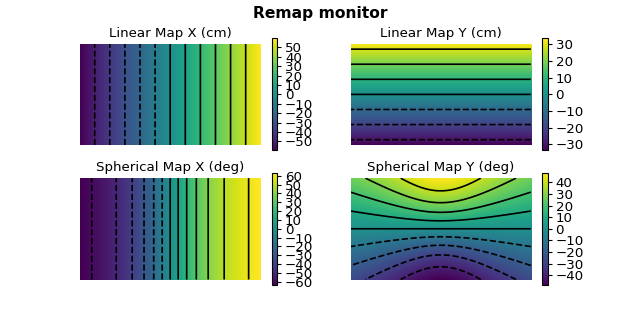

In [19]:
#### Get SPHERICAL coords
# remap_x, remap_y = remap(lin_coord_x, lin_coord_y)
# plot_remap(lin_coord_x, lin_coord_y, remap_x, remap_y)
remap_x, remap_y = remap(lin_coord_x, lin_coord_y)

print('Remapped spherical AZ [%.2f, %.2f], EL [%.2f, %.2f]' % (remap_x.min(), remap_x.max(), remap_y.min(), remap_y.max()))
print('Linear coords AZ [%.2f, %.2f], EL [%.2f, %.2f]' % (lin_coord_x.min(), lin_coord_x.max(), lin_coord_y.min(), lin_coord_y.max()))

plot_remap(lin_coord_x, lin_coord_y, remap_x, remap_y)

In [22]:
# from scipy.interpolate import griddata

# # Another way to do it...
# def cart2sph(x,y,z):
#     azimuth = np.arctan2(y,x)
#     elevation = np.arctan2(z,np.sqrt(x**2 + y**2))
#     r = np.sqrt(x**2 + y**2 + z**2)
#     return azimuth, elevation, r


In [23]:
# # Monitor size and position variables
# width_cm = 103; #%56.69;  % 103 width of screen, in cm
# height_cm = 58; #%34.29;  % 58 height of screen, in cm
# pxXmax = 1920; #%200; % number of pixels in an image that fills the whole screen, x
# pxYmax = 1080; #%150; % number of pixels in an image that fills the whole screen, y

# # Eye info
# cx = width_cm/2. # % eye x location, in cm
# cy = height_cm/2. # %11.42; % eye y location, in cm
# eye_dist = 30.; #% in cm

# # Distance to bottom of screen, along the horizontal eye line
# zdistBottom = np.sqrt((cy**2) + (eye_dist**2)) #; %24.49;     % in cm
# zdistTop    = np.sqrt((cy**2) + (eye_dist**2)) #; %14.18;     % in cm

# # Internal conversions
# top = height_cm-cy;
# bottom = -cy;
# right = cx;
# left = cx - width_cm;

# [xi, yi] = np.meshgrid(np.arange(0, pxXmax), np.arange(0, pxYmax))
# print(xi.shape, yi.shape)

# cart_pointsX = left + (float(width_cm)/pxXmax)*xi;
# cart_pointsY = top - (float(height_cm)/pxYmax)*yi;
# cart_pointsZ = zdistTop + ((zdistBottom-zdistTop)/float(pxYmax))*yi

# sphr_pointsTh, sphr_pointsPh, sphr_pointsR = cart2sph(cart_pointsZ, cart_pointsX, cart_pointsY)

((1080, 1920), (1080, 1920))
Remapped spherical AZ [-50.99, 50.99], EL [-34.79, 34.79]
Linear coords AZ [-59.70, 59.70], EL [-33.60, 33.60]


<IPython.core.display.Javascript object>


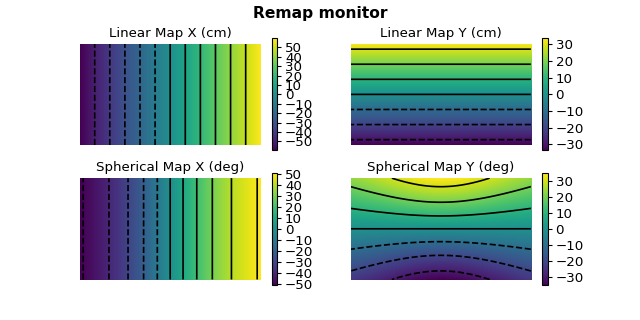

In [20]:
# Another way to do things...
cart_pointsX, cart_pointsY, sphr_pointsTh, sphr_pointsPh = putils.get_spherical_coords(cm_to_degrees=True) #cart_pointsX=px, cart_pointsY=py)
print('Remapped spherical AZ [%.2f, %.2f], EL [%.2f, %.2f]' 
      % (np.rad2deg(sphr_pointsTh).min(), np.rad2deg(sphr_pointsTh).max(), np.rad2deg(sphr_pointsPh).min(), np.rad2deg(sphr_pointsPh).max()))
print('Linear coords AZ [%.2f, %.2f], EL [%.2f, %.2f]' 
      % (cart_pointsX.min(), cart_pointsX.max(), cart_pointsY.min(), cart_pointsY.max()))
plot_remap(cart_pointsX, cart_pointsY, np.rad2deg(sphr_pointsTh), np.rad2deg(sphr_pointsPh))

# Reverse transform

In [402]:
uncorr_x = putils.warp_spherical(cart_pointsX, cart_pointsX, cart_pointsY, 
                                     sphr_pointsTh, sphr_pointsPh, normalize_range=True)
uncorr_y = putils.warp_spherical(cart_pointsY, cart_pointsX, cart_pointsY, 
                                     sphr_pointsTh, sphr_pointsPh, normalize_range=True)

plot_remap(cart_pointsX, cart_pointsY, uncorr_x, uncorr_y)

## Do reverse?

<IPython.core.display.Javascript object>


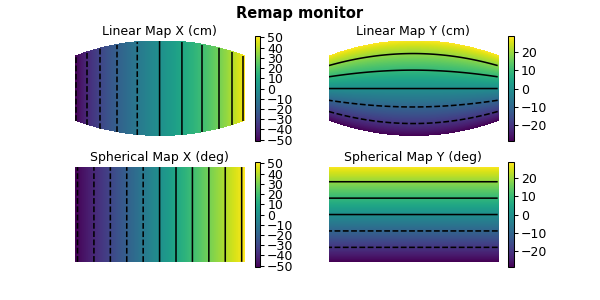

In [174]:
revcorr_x = putils.warp_spherical(uncorr_x, 
                                  sphr_pointsTh, sphr_pointsPh, 
                                  cart_pointsX, cart_pointsY, normalize_range=True, in_radians=False)
revcorr_y = putils.warp_spherical(uncorr_y, 
                                  sphr_pointsTh, sphr_pointsPh, 
                                  cart_pointsX, cart_pointsY, normalize_range=True, in_radians=False)

plot_remap(uncorr_x, uncorr_y, revcorr_x, revcorr_y)

### with remap

In [50]:
revcorr_x = putils.warp_spherical(uncorr_x, 
                                  remap_x, remap_y, 
                                  lin_coord_x, lin_coord_y, normalize_range=False, in_radians=False)
revcorr_y = putils.warp_spherical(uncorr_y, 
                                  remap_x, remap_y, 
                                  lin_coord_x, lin_coord_y, normalize_range=False, in_radians=False)




<IPython.core.display.Javascript object>


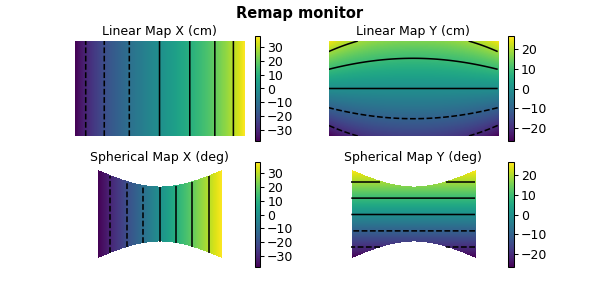

In [51]:
plot_remap(uncorr_x, uncorr_y, revcorr_x, revcorr_y)

# Test with checkerboard

In [767]:
def checkerboard(shape):
    return np.indices(shape).sum(axis=0) % 2


def checkerboard2(boardsize, squaresize):
    return np.fromfunction(lambda i, j: (i//squaresize[0])%2 != (j//squaresize[1])%2, boardsize).astype(int)
# if you want X squares per axis, do squaresize=[i//X for i in boardsize]

# boardsize=[1080, 1920]

# square_size_x = boardsize[1]//ncols #for i in boardsize]
# square_size_y = boardsize[0]//nrows
# print(square_size_x, square_size_y)

In [769]:
fit_params_orig

{u'col_vals': [-50.0,
  -45.0,
  -40.0,
  -35.0,
  -30.0,
  -25.0,
  -20.0,
  -15.0,
  -10.0,
  -5.0,
  0.0,
  5.0,
  10.0,
  15.0,
  20.0,
  25.0,
  30.0,
  35.0,
  40.0,
  45.0,
  50.0],
 u'column_spacing': 5.0,
 u'do_spherical_correction': False,
 'downsample_factor': 3.0,
 u'fit_desc': u'fit-2dgaus_dff-no-cutoff',
 u'fit_thr': 0.5,
 u'frame_rate': 44.6528,
 u'nframes_on': 22,
 u'nframes_per_trial': 89,
 u'nframes_post_onset': 22,
 u'post_stimulus_sec': 0.5,
 u'response_type': u'dff',
 u'rfdir': u'/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/combined_rfs_static/traces/traces001_f924db_traces001_85f376_traces001_db2b5e_traces001_acfba1_traces001_c58358_traces001_205616/receptive_fields/fit-2dgaus_dff-no-cutoff',
 u'row_spacing': 5.0,
 u'row_vals': [-25.0,
  -20.0,
  -15.0,
  -10.0,
  -5.0,
  0.0,
  5.0,
  10.0,
  15.0,
  20.0,
  25.0],
 u'scale_sigma': True,
 u'screen': {u'altitude_deg': 67.323,
  u'azimuth_deg': 119.5564,
  u'deg_per_pixel': [0.06226895833333333, 0.06233611111111

In [768]:
# Downsample screen (don't need full resolution)
downsampler=3.0
fit_params['downsample_factor'] = downsampler
row_vals = fit_params_orig['row_vals'] 
col_vals = fit_params_orig['col_vals']
resolution_ds = [int(i/downsampler) for i in fit_params_orig['screen']['resolution'][::-1]]
print("Screen resolution (ds=%.1fx): [%i, %i]" % (downsampler, resolution_ds[0], resolution_ds[1]))

# Linear coordinates
lin_x, lin_y = putils.get_lin_coords(resolution=resolution_ds)

# Spherical coordinates
cart_x, cart_y, sphr_x, sphr_y = putils.get_spherical_coords(cart_pointsX=lin_x, 
                                                           cart_pointsY=lin_y, 
                                                           cm_to_degrees=False) # coords alredy in deg

Screen resolution (ds=3.0x): [360, 640]


In [393]:
row_vals = fit_params_orig['row_vals']
col_vals = fit_params_orig['col_vals']
resolution = fit_params_orig['screen']['resolution'][::-1]

ncols = len(fit_params_orig['col_vals'])
nrows = len(fit_params_orig['row_vals'])

screen_bounds_pix=get_screen_lim_pixels(lin_coord_x, lin_coord_y, 
                                        row_vals=row_vals, col_vals=col_vals, pix_per_deg=screeninfo['pix_per_deg'])

(pix_bottom_edge, pix_left_edge, pix_top_edge, pix_right_edge) = screen_bounds_pix

stim_height = pix_bottom_edge-pix_top_edge+1
stim_width = pix_right_edge-pix_left_edge+1

stim_resolution = [stim_height, stim_width]
print(stim_resolution)

In [632]:
nr = len(row_vals)
nc = len(col_vals)
checkers = checkerboard((nr, nc))
checkmap = copy.copy(checkers)

# Upsample RF map to screen pixels
check_orig = fitrf.resample_map(checkmap, cart_x, cart_y, 
                          row_vals=row_vals, col_vals=col_vals,
                          resolution=resolution_ds)
# Warp resampled RF map
check_corrected = putils.warp_spherical(check_orig, 
                                        sphr_x, sphr_y, 
                                        cart_x, cart_y, normalize_range=True, method='linear')
# Trim
check_trim  = check_orig[pix_top_edge:pix_bottom_edge, pix_left_edge:pix_right_edge]
check_corr_trim  = check_corrected[pix_top_edge:pix_bottom_edge, pix_left_edge:pix_right_edge]

# Downsample, so we don't have repeated values
check_o = cv2.resize(check_trim, (ncols, nrows))
check_w = cv2.resize(check_corr_trim, (ncols, nrows))

# Get downsampled coordinates
# Trim and downsample coordinate space to match corrected map
cart_x_ds  = cv2.resize(cart_x[pix_top_edge:pix_bottom_edge, pix_left_edge:pix_right_edge], (ncols,nrows))
cart_y_ds  = cv2.resize(cart_y[pix_top_edge:pix_bottom_edge, pix_left_edge:pix_right_edge], (ncols, nrows))

sphr_x_ds  = cv2.resize(sphr_x[pix_top_edge:pix_bottom_edge, pix_left_edge:pix_right_edge], (ncols,nrows))
sphr_y_ds  = cv2.resize(sphr_y[pix_top_edge:pix_bottom_edge, pix_left_edge:pix_right_edge], (ncols, nrows))


<IPython.core.display.Javascript object>


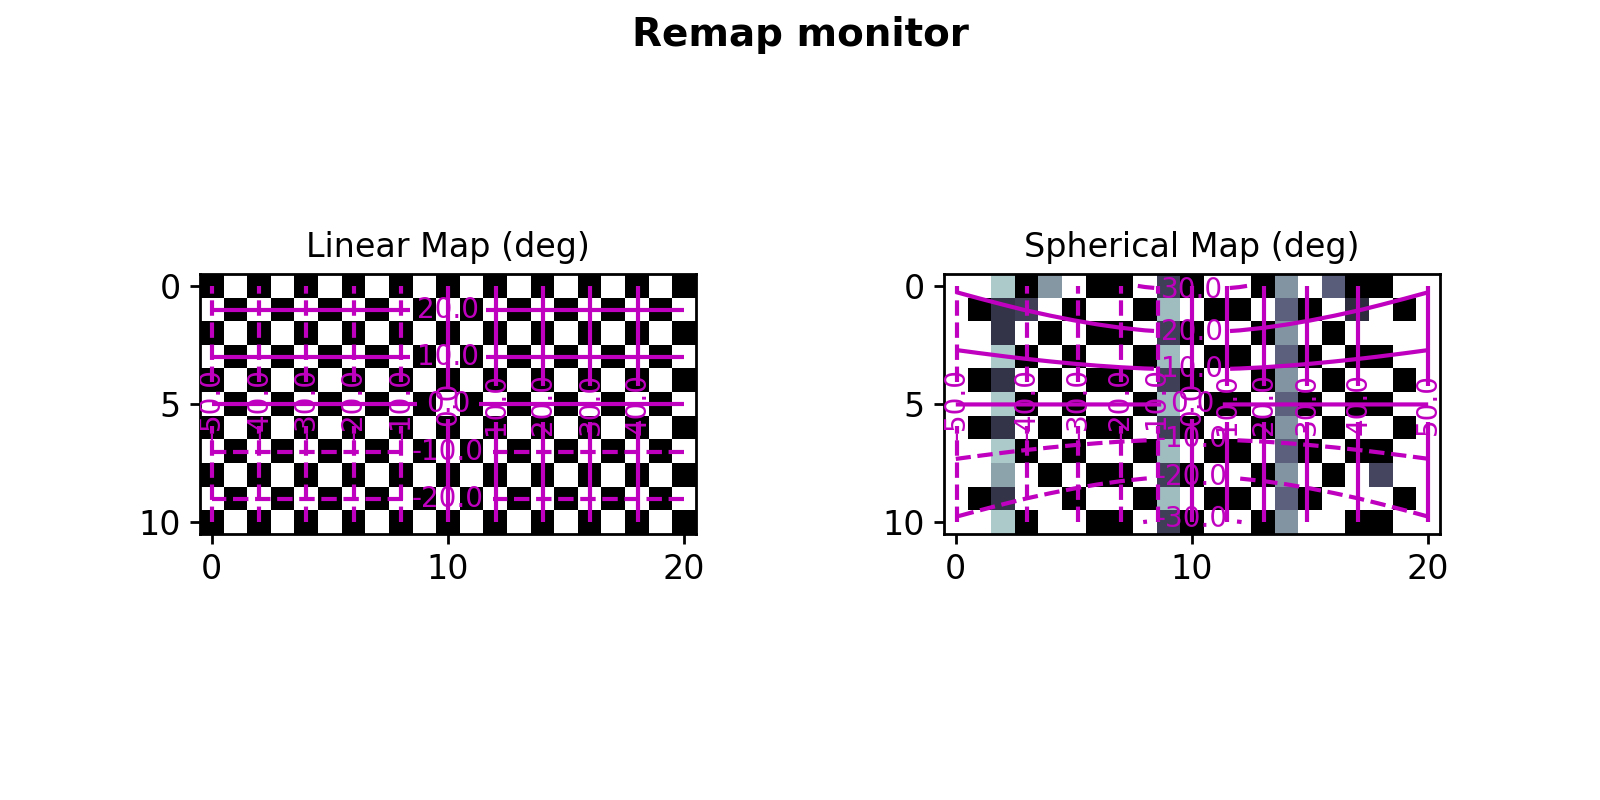

In [635]:
fig = plot_corrected_gridlines(check_o, check_w, cart_x_ds, cart_y_ds, sphr_x_ds, sphr_y_ds, 
                             col_vals=col_vals, row_vals=row_vals, interval=10)

## warp

In [498]:
remap_x, remap_y = remap(cart_x, cart_y, resolution=(ny, nx))


<IPython.core.display.Javascript object>


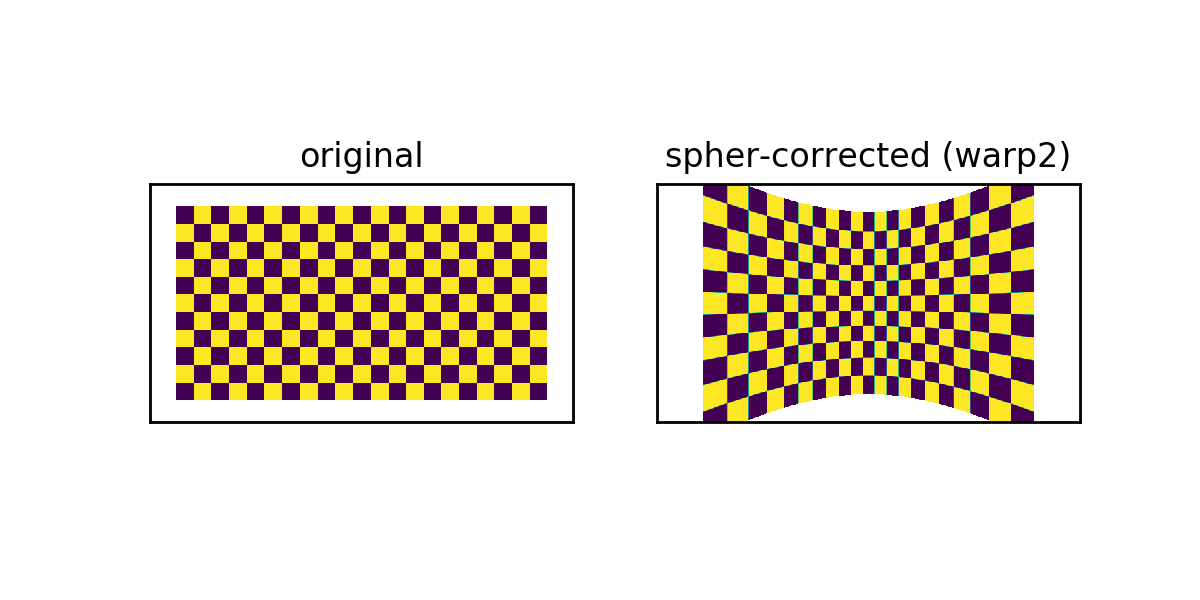

In [636]:
fig, axn = pl.subplots(1,2, figsize=(6,3))

axn[0].imshow(check_orig) #, cmap='gray')
axn[0].set_title('original')
axn[1].imshow(check_corrected) #, cmap='gray')
axn[1].set_title('spher-corrected (warp2)')
for ax in axn:
    ax.tick_params(which='both', axis='both', size=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

## Test 1 RF map

In [770]:
reload(fitrf)

<module 'pipeline.python.retinotopy.fit_2d_rfs' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/retinotopy/fit_2d_rfs.pyc'>

In [772]:
fitrf.get_fit_desc(do_spherical_correction=True)

'fit-2dgaus_dff_sphr'

In [773]:
rfname = 'rfs10'
fit_results_orig, fit_params_orig = fitrf.load_fit_results(animalid, session, 'FOV%i_zoom2p0x' % fovnum,
                                        experiment=rfname, traceid=traceid,
                                        response_type=response_type, do_spherical_correction=False)

fit_results_warp, fit_params_warp = fitrf.load_fit_results(animalid, session, 'FOV%i_zoom2p0x' % fovnum,
                                        experiment=rfname, traceid=traceid,
                                        response_type=response_type, do_spherical_correction=True)

In [774]:
row_vals=fit_params_orig['row_vals']
col_vals = fit_params_orig['col_vals']

fitdf_orig = fitrf.rfits_to_df(fit_results_orig, row_vals=row_vals, col_vals=col_vals)
fitdf_warp = fitrf.rfits_to_df(fit_results_warp, row_vals=row_vals, col_vals=col_vals)


In [775]:
print("N fit (orig): %i" % len([k for k, v in fit_results_orig.items() if v['r2']>0.5]))
print("N fit (warp): %i" % len([k for k, v in fit_results_warp.items() if v['r2']>0.5]))


N fit (orig): 102
N fit (warp): 83


<IPython.core.display.Javascript object>


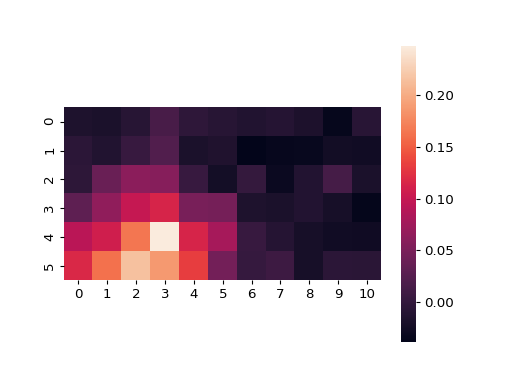

In [778]:
rid=227 #61
fig, ax = pl.subplots()
sns.heatmap(fit_results_orig[rid]['data'], ax=ax)
ax.set_aspect('equal')


## refit RF map

In [22]:
def get_stimulus_limits_deg(fit_params):
    xmin_deg = min(fit_params['col_vals']) - fit_params['column_spacing']/2.
    xmax_deg = max(fit_params['col_vals']) + fit_params['column_spacing']/2.
    ymin_deg = min(fit_params['row_vals']) - fit_params['row_spacing']/2.
    ymax_deg = max(fit_params['row_vals']) + fit_params['row_spacing']/2.
    return (xmin_deg, xmax_deg), (ymin_deg, ymax_deg)

In [779]:
fit_params=fit_params_orig

In [780]:
# Downsample screen (don't need full resolution)
downsampler=3.0
fit_params['downsample_factor'] = downsampler
row_vals = fit_params['row_vals'] 
col_vals = fit_params['col_vals']
resolution_ds = [int(i/downsampler) for i in fit_params['screen']['resolution'][::-1]]
print("Screen resolution (ds=%.1fx): [%i, %i]" % (downsampler, resolution_ds[0], resolution_ds[1]))

# Linear coordinates
lin_x, lin_y = putils.get_lin_coords(resolution=resolution_ds)

# Spherical coordinates
cart_x, cart_y, sphr_x, sphr_y = putils.get_spherical_coords(cart_pointsX=lin_x, 
                                                           cart_pointsY=lin_y, 
                                                           cm_to_degrees=False) # coords alredy in deg
print(sphr_x.shape, cart_x.shape)

Screen resolution (ds=3.0x): [360, 640]
((360, 640), (360, 640))


<IPython.core.display.Javascript object>


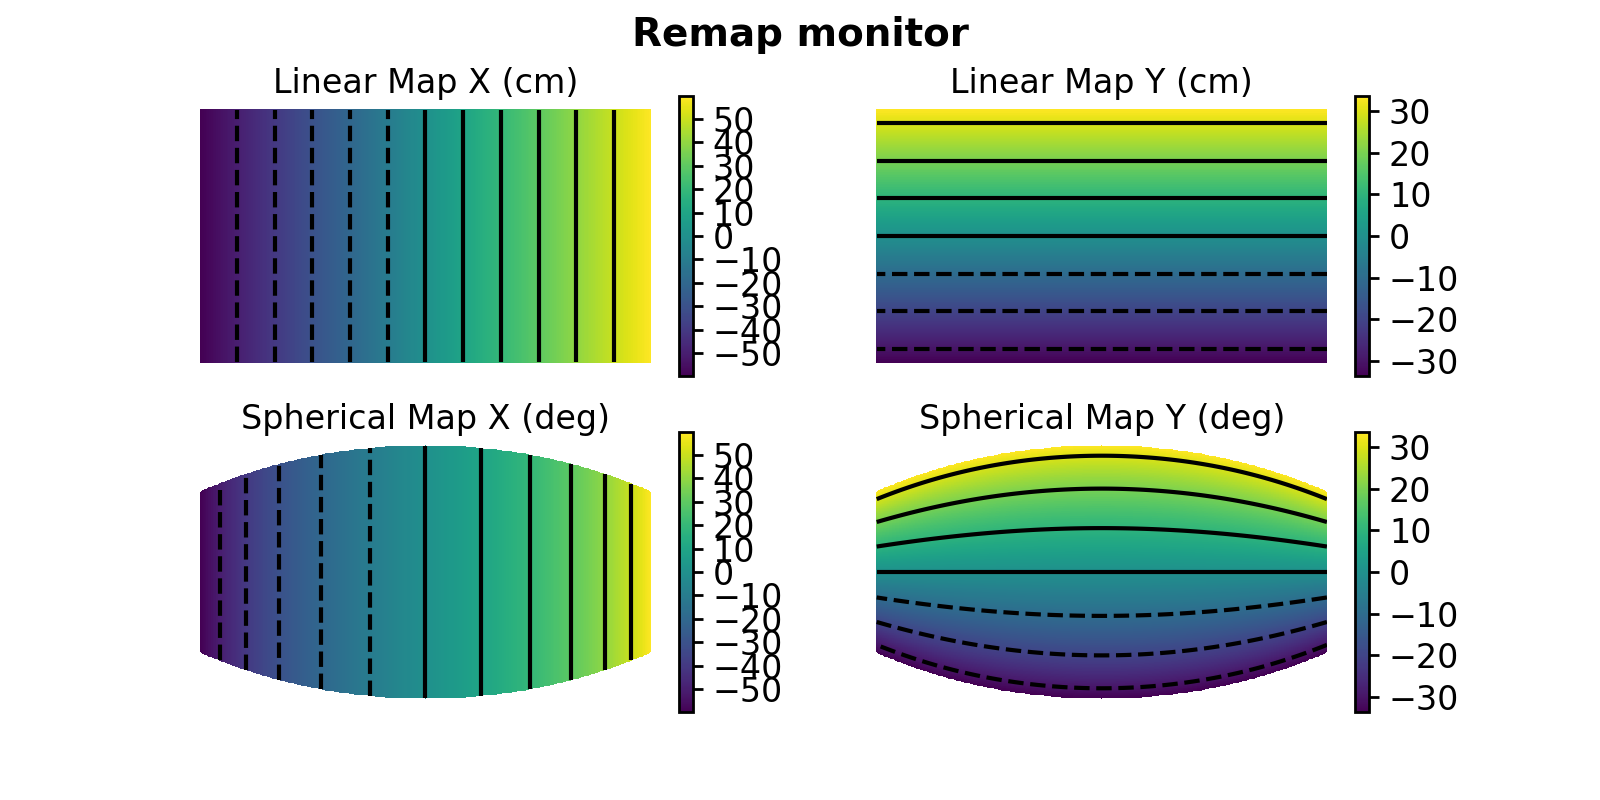

In [37]:
plot_correction=True
if plot_correction:
    warp_x = putils.warp_spherical(cart_x, cart_x, cart_y, 
                                     sphr_x, sphr_y, normalize_range=True)
    warp_y = putils.warp_spherical(cart_y, cart_x, cart_y, 
                                         sphr_x, sphr_y, normalize_range=True)
    plot_remap(cart_x, cart_y, warp_x, warp_y, interval=10, resolution=resolution_ds)

#### Test with 1 roi's rfmap

In [786]:
import cv2

In [787]:
def plot_corrected_coordinate_spaces(rfmap_orig, rfmap_corrected, resolution_ds, cart_x, cart_y, sphr_x, sphr_y, 
                                     interval=10):

    #if mapcorX is None or mapcorY is None:
    mapcorX, mapcorY = np.meshgrid(range(resolution_ds[1]), range(resolution_ds[0]))

    fig, axn = pl.subplots(2,2, figsize=(8, 4))
    fig.suptitle('Remap monitor', fontsize=14, fontweight='bold')

    ax = axn[0,0]
    ax.set_title('Linear Map X (cm)')
    currfig = ax.imshow(cart_x, alpha=0.3)
    ax.imshow(rfmap_orig)
    levels1 = range(int(np.floor(np.nanmin(cart_x) / interval) * interval),
                    int((np.ceil(np.nanmax(cart_x) / interval) + 1) * interval), interval)
    im1 = ax.contour(mapcorX, mapcorY, cart_x, levels1, colors='k', linewidth=2)
    #ax.clabel(im1, fontsize=10, inline=1, fmt='%2.1f')
    #fig.colorbar(currfig, ticks=col_vals)
    #pl.gca().set_axis_off()

    ax=axn[0,1]
    ax.set_title('Linear Map Y (cm)')
    currfig = ax.imshow(cart_y, alpha=0.3)
    ax.imshow(rfmap_orig)
    levels2 = range(int(np.floor( np.nanmin(cart_y) / interval) * interval),
                    int((np.ceil( np.nanmax(cart_y) / interval) + 1) * interval), interval)
    im2 = ax.contour(mapcorX, mapcorY, cart_y, levels2, colors='k', linewidth=2)
    ax.clabel(im2, fontsize=10, inline=1, fmt='%2.1f')
    #f1.colorbar(currfig, ticks=levels2)
    #pl.gca().set_axis_off()

    ax=axn[1,0]
    ax.set_title('Spherical Map X (deg)')
    deg_x = np.rad2deg(sphr_x)
    currfig = ax.imshow(deg_x, alpha=0.3)
    ax.imshow(rfmap_corrected)
    levels3 = range(int(np.floor( np.nanmin(deg_x) / interval) * interval),
                    int((np.ceil( np.nanmax(deg_x) / interval) + 1) * interval), interval)
    im3 = ax.contour(mapcorX, mapcorY, deg_x, levels3, colors='k', linewidth=2)
    ax.clabel(im3, fontsize=10, inline=1, fmt='%2.1f')
    #f1.colorbar(currfig, ticks=levels3)
    #pl.gca().set_axis_off()


    ax=axn[1,1]
    ax.set_title('Spherical Map Y (deg)')
    deg_y = np.rad2deg(sphr_y)
    currfig = ax.imshow(deg_y, alpha=0.3)
    ax.imshow(rfmap_corrected)
    levels4 = range(int(np.floor( np.nanmin(deg_y) / interval) * interval),
                    int((np.ceil( np.nanmax(deg_y) / interval) + 1) * interval), interval)
    im4 = ax.contour(mapcorX, mapcorY, deg_y, levels4, colors='k', linewidth=2)
    ax.clabel(im4, fontsize=10, inline=1, fmt='%2.1f')

    #f1.colorbar(currfig, ticks=row_vals)
    #pl.gca().set_axis_off()
    
    return fig


In [794]:
def plot_corrected_gridlines(rfmap_o, rfmap_w, 
                             cart_x_ds, cart_y_ds, sphr_x_ds, sphr_y_ds, 
                             col_vals=None, row_vals=None, interval=10, 
                             lw=0.5, line_color='m', cmap='bone'):
    
    mapcorX, mapcorY = np.meshgrid(range(len(col_vals)), range(len(row_vals)))

    fig, axn = pl.subplots(1,2, figsize=(8, 4))
    fig.suptitle('Remap monitor', fontsize=14, fontweight='bold')

    ax = axn[0]
    ax.set_title('Linear Map (deg)')
    currfig = ax.imshow(cart_x_ds, alpha=0.0)
    levels1 = range(int(np.floor(np.nanmin(cart_x_ds) / interval) * interval),
                    int((np.ceil(np.nanmax(cart_x_ds) / interval) + 1) * interval), interval)
    im1 = ax.contour(mapcorX, mapcorY, cart_x_ds, levels1, colors=line_color, linewidth=lw)
    ax.clabel(im1, fontsize=10, inline=1, fmt='%2.1f')
    currfig = ax.imshow(cart_y_ds, alpha=0.0)
    levels2 = range(int(np.floor( np.nanmin(cart_y_ds) / interval) * interval),
                    int((np.ceil( np.nanmax(cart_y_ds) / interval) + 1) * interval), interval)
    im2 = ax.contour(mapcorX, mapcorY, cart_y_ds, levels2, colors=line_color, linewidth=lw)
    ax.clabel(im2, fontsize=10, inline=1, fmt='%2.1f')
    ax.imshow(rfmap_o, cmap=cmap)


    ax=axn[1]
    ax.set_title('Spherical Map (deg)')
    deg_x_ds = np.rad2deg(sphr_x_ds)
    currfig = ax.imshow(deg_x_ds, alpha=0.)
    levels3 = range(int(np.floor( np.nanmin(deg_x_ds) / interval) * interval),
                    int((np.ceil( np.nanmax(deg_x_ds) / interval) + 1) * interval), interval)
    im3 = ax.contour(mapcorX, mapcorY, deg_x_ds, levels3, colors=line_color, linewidth=lw)
    ax.clabel(im3, fontsize=10, inline=1, fmt='%2.1f')

    deg_y_ds = np.rad2deg(sphr_y_ds)
    currfig = ax.imshow(deg_y_ds, alpha=0.0)
    levels4 = range(int(np.floor( np.nanmin(deg_y_ds) / interval) * interval),
                    int((np.ceil( np.nanmax(deg_y_ds) / interval) + 1) * interval), interval)
    im4 = ax.contour(mapcorX, mapcorY, deg_y_ds, levels4, colors=line_color, linewidth=lw)
    ax.clabel(im4, fontsize=10, inline=1, fmt='%2.1f')

    ax.imshow(rfmap_w, cmap=cmap)

    pl.subplots_adjust(wspace=0.5, hspace=0.5)

    return fig

In [795]:
def deg_warp_lut(deg_x, deg_y, warp_x, warp_y):
    '''
    From: https://github.com/zhuangjun1981/retinotopic_mapping/blob/master/retinotopic_mapping/MonitorSetup.py
    same as generate_lookup_table()
    '''
    lookup_i = np.zeros(warp_x.shape).astype(np.int32)
    lookup_j = np.zeros(warp_x.shape).astype(np.int32)

    for j in xrange(lookup_i.shape[1]):
        currDegX = warp_x[0, j]
        diffDegX = deg_x[0, :] - currDegX
        indJ = np.argmin(np.abs(diffDegX))
        lookup_j[:, j] = indJ

        for i in xrange(lookup_j.shape[0]):
            currDegY = warp_y[i, j]
            diffDegY = deg_y[:, indJ] - currDegY
            indI = np.argmin(np.abs(diffDegY))
            lookup_i[i, j] = indI
    return lookup_i, lookup_j

In [788]:
ncols = len(col_vals)
nrows = len(row_vals)

# Get screen bounds in pixel space
screen_bounds_pix = fitrf.get_screen_lim_pixels(cart_x, cart_y, row_vals=row_vals, col_vals=col_vals)
(pix_bottom_edge, pix_left_edge, pix_top_edge, pix_right_edge) = screen_bounds_pix

# Adjust pix_per_deg for downsampled screen resolution
pix_per_deg = screeninfo['pix_per_deg'] / downsampler
print("Downsampled screen by %ix (~%.2f pix/deg)" % (downsampler, pix_per_deg))

# Double check that adjustments match for stimulus size
expected_sz_x = (pix_right_edge-pix_left_edge+1) * (1./pix_per_deg) / ncols
expected_sz_y = (pix_bottom_edge-pix_top_edge+1) * (1./pix_per_deg) / nrows
print("tile sz-x, -y should be ~(%.2f, %.2f) deg" % (expected_sz_x, expected_sz_y))

Downsampled screen by 3x (~5.35 pix/deg)
tile sz-x, -y should be ~(10.03, 10.03) deg


In [790]:
rid = 227 #32 #61
rfmap = fit_results_orig[rid]['data'].copy()

# Upsample RF map to screen pixels
rfmap_orig = fitrf.resample_map(rfmap, cart_x, cart_y, 
                          row_vals=row_vals, col_vals=col_vals,
                          resolution=resolution_ds)
# Warp resampled RF map
rfmap_corrected = putils.warp_spherical(rfmap_orig, sphr_x, sphr_y, 
                                          cart_x, cart_y, normalize_range=True, method='linear')
# Trim
rfmap_trim  = rfmap_orig[pix_top_edge:pix_bottom_edge, pix_left_edge:pix_right_edge]
rfmap_corr_trim  = rfmap_corrected[pix_top_edge:pix_bottom_edge, pix_left_edge:pix_right_edge]

# Downsample, so we don't have repeated values
rfmap_o = cv2.resize(rfmap_trim, (ncols, nrows))
rfmap_w = cv2.resize(rfmap_corr_trim, (ncols, nrows))

<IPython.core.display.Javascript object>


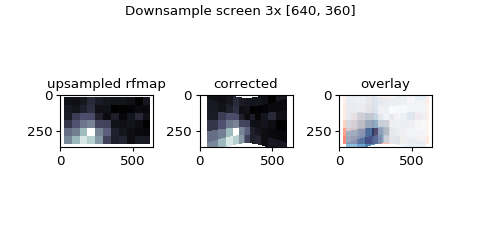

In [791]:
fig, axn = pl.subplots(1, 3, figsize=(6,3))
ax = axn[0]
ax.imshow(rfmap_orig, cmap='bone')
ax.set_title('upsampled rfmap')

ax = axn[1]
ax.imshow(rfmap_corrected, cmap='bone')
ax.set_title('corrected')

ax = axn[2]
ax.imshow(rfmap_orig, alpha=0.7, cmap='Reds')
ax.imshow(rfmap_corrected, alpha=0.7, cmap='Blues')
ax.set_title('overlay')

for ax in axn:
    ax.set_aspect('equal')

fig.suptitle("Downsample screen %ix [%i, %i]" % (downsampler, 
                                                 resolution_ds[1], resolution_ds[0]))

pl.subplots_adjust(wspace=0.5, hspace=0.5)

<IPython.core.display.Javascript object>


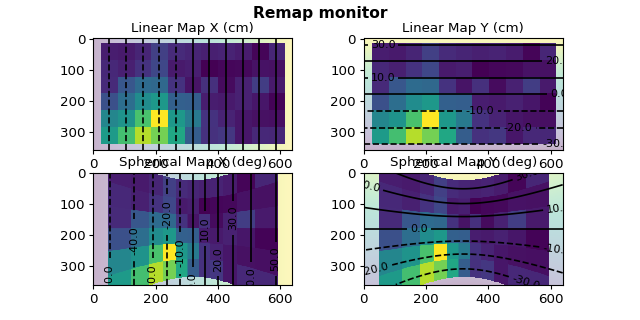

In [792]:
fig = plot_corrected_coordinate_spaces(rfmap_orig, rfmap_corrected, resolution_ds, cart_x, cart_y, sphr_x, sphr_y, interval=10)

# test fit

#### Get transformation

In [793]:
fit_r = fitrf.do_2d_fit(rfmap_o, nx=len(col_vals), ny=len(row_vals))
fit_w = fitrf.do_2d_fit(rfmap_w, nx=len(col_vals), ny=len(row_vals))

amp, x0, y0, sx, sy, th, off = fit_results_orig[rid]['fit_r']['popt']
r2 = fit_results_orig[rid]['fit_r']['r2']
print("Orig (R2=%.2f): x0=%.2f, y0=%.2f, sx=%.2f, sy=%.2f, theta=%.2f" 
      % (r2, x0, y0, sx, sy, th))

amp, x0, y0, sx, sy, th, off = fit_r[0]['popt']
r2 = fit_r[0]['r2']
print("Cart (R2=%.2f): x0=%.2f, y0=%.2f, sx=%.2f, sy=%.2f, theta=%.2f" 
      % (r2, x0, y0, sx, sy, th))

amp_w, x0_w, y0_w, sx_w, sy_w, th_w, off_w = fit_w[0]['popt']
r2_w = fit_w[0]['r2']
print("Warp (R2=%.2f): x0=%.2f, y0=%.2f, sx=%.2f, sy=%.2f, theta=%.2f" 
      % (r2_w, x0_w, y0_w, sx_w, sy_w, th_w))


Orig (R2=0.94): x0=2.28, y0=4.86, sx=1.88, sy=1.69, theta=-0.58
Cart (R2=0.94): x0=2.28, y0=4.86, sx=1.88, sy=1.69, theta=-0.58
Warp (R2=0.92): x0=2.52, y0=5.17, sx=1.98, sy=1.83, theta=-0.77


<IPython.core.display.Javascript object>


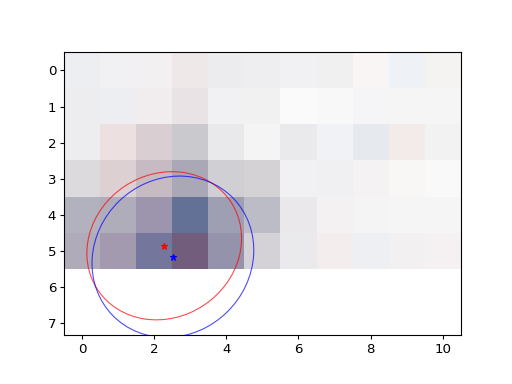

In [812]:
fig, ax = pl.subplots() #pl.figure()
ax.imshow(rfmap_o, cmap='Reds', alpha=0.5)
ax.plot(x0, y0, 'r*')

ell = Ellipse((x0, y0), abs(sx*sigma_scale), abs(sy*sigma_scale), angle=np.rad2deg(th))
ell.set_alpha(0.7)
ell.set_edgecolor('r')
ell.set_facecolor('none')
ell.set_linewidth(1)
ax.add_patch(ell) 


pl.imshow(rfmap_w, cmap='Blues', alpha=0.5)
pl.plot(x0_w, y0_w, 'b*')

ell = Ellipse((x0_w, y0_w), abs(sx_w*sigma_scale), abs(sy_w*sigma_scale), angle=np.rad2deg(th_w))
ell.set_alpha(0.7)
ell.set_edgecolor('b')
ell.set_facecolor('none')
ell.set_linewidth(1)
ax.add_patch(ell) 

In [796]:
# lut_i, lut_j = deg_warp_lut(cart_x_ds, cart_y_ds, np.rad2deg(sphr_x_ds), np.rad2deg(sphr_y_ds))

In [797]:
# Trim and downsample coordinate space to match corrected map
cart_x_ds  = cv2.resize(cart_x[pix_top_edge:pix_bottom_edge, pix_left_edge:pix_right_edge], (ncols,nrows))
cart_y_ds  = cv2.resize(cart_y[pix_top_edge:pix_bottom_edge, pix_left_edge:pix_right_edge], (ncols, nrows))

sphr_x_ds  = cv2.resize(sphr_x[pix_top_edge:pix_bottom_edge, pix_left_edge:pix_right_edge], (ncols,nrows))
sphr_y_ds  = cv2.resize(sphr_y[pix_top_edge:pix_bottom_edge, pix_left_edge:pix_right_edge], (ncols, nrows))

<IPython.core.display.Javascript object>


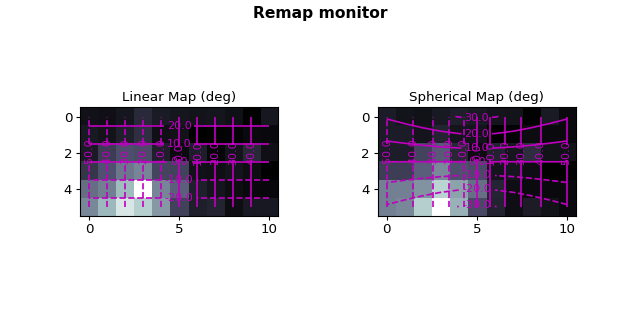

In [798]:
fig = plot_corrected_gridlines(rfmap_o, rfmap_w,
                               cart_x_ds, cart_y_ds, sphr_x_ds, sphr_y_ds, 
                               col_vals=col_vals, row_vals=row_vals, interval=10)

In [816]:
from scipy import interpolate
import math



nx = len(col_vals)
ny = len(row_vals)
grid_x, grid_y = np.meshgrid(range(nx),range(ny)[::-1])

grid_points = np.array( (grid_x.flatten(), grid_y.flatten()) ).T
cart_values = np.array( (cart_x_ds.flatten(), cart_y_ds.flatten()) ).T
sphr_values = np.array( (np.rad2deg(sphr_x_ds).flatten(), np.rad2deg(sphr_y_ds).flatten()) ).T

def extend_range(x):
    dx = (x[1] - x[0]) / 2
    return np.append( x - dx, x[-1] + dx)


In [823]:
# f = interpolate.interp2d(grid_x.flatten(), grid_y.flatten(), cart_values, kind='cubic')
# f(x0, y0)

interpolator = interpolate.CloughTocher2DInterpolator(grid_points, sphr_values)
interpolator(x0_w, y0_w)


array([ nan,  nan])

In [817]:
x0_scaled, y0_scaled = interpolate.griddata(grid_points, cart_values, (x0, y0))
x0_w_scaled, y0_w_scaled = interpolate.griddata(grid_points, sphr_values, (x0_w, y0_w))
print("Orig centroid: (%.2f, %.2f) v (%.2f, %.2f)" % (x0_scaled, y0_scaled, x0, y0))
print("Warped centroid: (%.2f, %.2f) v (%.2f, %.2f)" % (x0_w_scaled, y0_w_scaled, x0_w, y0_w))

Orig centroid: (-27.33, 23.73) v (2.28, 4.86)
Warped centroid: (nan, nan) v (2.52, 5.17)


In [800]:
cart_values.min(), cart_values.max()

(-50.0102615694165, 49.823407109322595)

In [310]:
fitdf_warp = fitrf.rfits_to_df(fit_results_warp, fit_params=fit_params_warp, 
                               row_vals=row_vals, col_vals=col_vals,
                              convert_coords=True, spherical=True)


In [311]:
fitdf_warp.loc[rid]

r2          0.521644
sigma_x    28.515445
sigma_y    14.154651
theta       6.239919
x0         21.688012
y0        -12.417869
Name: 32, dtype: float64

In [155]:
x0_w, y0_w, sx_w, sy_w

(13.352625330687534,
 2.9955630176242467,
 2.0594901260621805,
 0.9919755507563425)

In [249]:
reload(fitrf)

<module 'pipeline.python.retinotopy.fit_2d_rfs' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/retinotopy/fit_2d_rfs.pyc'>

In [286]:
fitdf_orig2.head()


,r2,sigma_x,sigma_y,theta,x0,y0
2,0.549391,1.872341,1.374269,0.473589,16.564461,5.181655
3,0.189189,1.125536,2.347007,1.275515,16.319090,5.137816
4,0.639729,1.767596,1.085641,0.158482,16.598258,5.281796
5,0.264231,1.308752,0.999239,0.220223,17.397014,8.178461
6,0.078002,3.504855,0.253752,0.028734,-0.793828,8.312852


In [288]:
fitdf_orig.head()

,r2,sigma_x,sigma_y,theta,x0,y0
2,0.549391,22.000012,16.147665,0.473589,32.822307,0.908274
3,0.189189,13.225048,27.577338,1.275515,31.595451,0.689082
4,0.639729,20.769255,12.756278,0.158482,32.991289,1.408980
5,0.264231,15.377836,11.741057,0.220223,36.985069,15.892306
6,0.078002,41.182047,2.981590,0.028734,-53.969139,16.564258


In [293]:
def apply_scaling_to_df(row, grid_points=None, new_values=None, scale_sigma=True):
    r2 = row['r2']
    theta = row['theta']
    x0, y0, sx, sy = fitrf.get_scaled_sigmas(grid_points, new_values,
                                             row['x0'], row['y0'], 
                                             row['sigma_x'], row['sigma_y'], row['theta'],
                                             scale_sigma=scale_sigma)
    return r2, sx, sy, theta, x0, y0

In [294]:
def convert_fit_to_coords_spherical(fitdf, fit_params, sigma_scale=2.35, spherical=True):
    grid_points, cart_values, sphr_values = fitrf.coordinates_for_transformation(fit_params)
    
    if spherical:
        converted = fitdf.apply(apply_scaling_to_df, args=(grid_points, sphr_values), axis=1)
    else:
        converted = fitdf.apply(apply_scaling_to_df, args=(grid_points, cart_values), axis=1)
    newdf = pd.DataFrame([[r2, sx*sigma_scale, sy*sigma_scale, th, x0, y0] 
                          for r2, sx, sy, th, x0, y0 in converted.values], 
                             index=converted.index, 
                             columns=['r2', 'sigma_x', 'sigma_y', 'theta', 'x0', 'y0'])
    return newdf
    


In [295]:
newdf = convert_fit_to_coords_spherical(fitdf_orig2, fit_params_orig, spherical=False)

newdf_warp = convert_fit_to_coords_spherical(fitdf_warp, fit_params_warp, spherical=True)


In [296]:
print(rid)
print('----- orig -----') 
for param in ['x0', 'y0', 'sigma_x', 'sigma_y']:
    print(param, 'orig: %.2f, new: %.2f' % (fitdf_orig[param][rid], newdf[param][rid]))
print('----- corrected -----') 
for param in ['x0', 'y0', 'sigma_x', 'sigma_y']:
    print(param, 'orig: %.2f, new: %.2f' % (fitdf_orig[param][rid], newdf_warp[param][rid]))



32
----- orig -----
('x0', 'orig: 23.38, new: 23.25')
('y0', 'orig: -9.85, new: -9.73')
('sigma_x', 'orig: 27.72, new: 27.67')
('sigma_y', 'orig: 9.52, new: 9.49')
----- corrected -----
('x0', 'orig: 23.38, new: 21.69')
('y0', 'orig: -9.85, new: -12.42')
('sigma_x', 'orig: 27.72, new: 28.52')
('sigma_y', 'orig: 9.52, new: 14.15')


In [297]:
fitdf_orig.head()

,r2,sigma_x,sigma_y,theta,x0,y0
2,0.549391,22.000012,16.147665,0.473589,32.822307,0.908274
3,0.189189,13.225048,27.577338,1.275515,31.595451,0.689082
4,0.639729,20.769255,12.756278,0.158482,32.991289,1.408980
5,0.264231,15.377836,11.741057,0.220223,36.985069,15.892306
6,0.078002,41.182047,2.981590,0.028734,-53.969139,16.564258


In [235]:
testdf = fdf.copy()
x = testdf.apply(apply_scaling_to_df, args=(grid_points, sphr_values), axis=1)
x = pd.DataFrame([[r2, x0, y0, sx, sy, th] for r2,x0,y0,sx,sy,th in x.values], 
             index=x.index, columns=['r2', 'x0', 'y0', 'sigma_x', 'sigma_y', 'theta'])


In [197]:
def get_scaled_sigmas(x0, y0, sx, sy, th, grid_points=None, new_values=None, scale_sigma=True):

    x0_scaled, y0_scaled = interpolate.griddata(grid_points, new_values, (x0, y0))
    x0_scaled, y0_scaled = interpolate.griddata(grid_points, new_values, (x0, y0))

    # Get flanking points spanned by sx, sy
    sx_linel, sx_line2, sy_line1, sy_line2 = get_endpoints_from_sigma(x0, y0, sx, sy, th, scale_sigma=False)

    # Get distances
    if scale_sigma:
        sx_x1_sc, sx_y1_sc = interpolate.griddata(grid_points, new_values, sx_linel) # Convert coord to new_vals
        sx_x2_sc, sx_y2_sc = interpolate.griddata(grid_points, new_values, sx_line2) # Convert coord to new_vals
        sx_scaled = math.hypot(sx_x2_sc - sx_x1_sc, sx_y2_sc - sx_y1_sc)
    else:
        #sx_scaled = math.hypot(sx_x2 - sx_x1, sx_y2 - sx_y1)
        sx_scaled = math.hypot(sx_line2[0] - sx_linel[0], sx_line2[1] - sx_linel[1])

    if scale_sigma:
        sy_x1_sc, sy_y1_sc = interpolate.griddata(grid_points, new_values, sy_line1)
        sy_x2_sc, sy_y2_sc = interpolate.griddata(grid_points, new_values, sy_line2)
        sy_scaled = math.hypot(sy_x2_sc - sy_x1_sc, sy_y2_sc - sy_y1_sc)
    else:
        #sy_scaled = math.hypot(sy_x2 - sy_x1, sy_y2 - sy_y1)
        sy_scaled = math.hypot(sy_line2[0] - sy_line1[0], sy_line2[1] - sy_line1[1])
    
    return x0_scaled, y0_scaled, abs(sx_scaled), abs(sy_scaled)

In [136]:
print('x0', x0, x0_w)
print('y0', y0, y0_w)
print('sx', sx, sx_w)
print('sy', sy, sy_w)

('x0', 14.675930205820036, 13.352625330687534)
('y0', 3.0294699427698952, 2.9955630176242467)
('sx', 2.3592295235037493, 2.0594901260621805)
('sy', 0.8101949805947775, 0.9919755507563425)


In [137]:
x0_scaled, y0_scaled, sx_scaled, sy_scaled = get_scaled_sigmas(grid_points, cart_values, x0, y0, sx, sy, th)
print('x0', x0_scaled, x0)
print('y0', y0_scaled, y0)
print('sx', sx_scaled*2.35, sx)
print('sy', sy_scaled*2.35, sy)

print(fitdf_orig.loc[rid])

('x0', 23.24733611659035, 14.675930205820036)
('y0', -9.731412665190652, 3.0294699427698952)
('sx', 27.674802531288673, 2.3592295235037493)
('sy', 9.493092935576428, 0.8101949805947775)
r2          0.588694
sigma_x    27.720947
sigma_y     9.519791
theta       6.249570
x0         23.379651
y0         -9.852650
Name: 32, dtype: float64


In [139]:
x0_w_scaled, y0_w_scaled, sx_w_scaled, sy_w_scaled = get_scaled_sigmas(grid_points, sphr_values, x0_w, y0_w, sx_w, sy_w, th_w)
print('x0', x0_scaled, x0_w_scaled)
print('y0', y0_scaled, y0_w_scaled)
print('sx', sx_scaled*2.35, sx_w_scaled*2.35)
print('sy', sy_scaled*2.35, sy_w_scaled*2.35)

('x0', 23.24733611659035, 21.688012299091024)
('y0', -9.731412665190652, -12.417868655827625)
('sx', 27.674802531288673, 28.51544507572566)
('sy', 9.493092935576428, 14.154650682975443)


In [144]:
sx_linel, sx_line2, sy_line1, sy_line2 = get_endpoints_from_sigma(x0, y0, sx, sy, th, scale_sigma=True)
sx_linel_w, sx_line2_w, sy_line1_w, sy_line2_w = get_endpoints_from_sigma(x0_w, y0_w, sx_w, sy_w, th_w, scale_sigma=True)


<IPython.core.display.Javascript object>


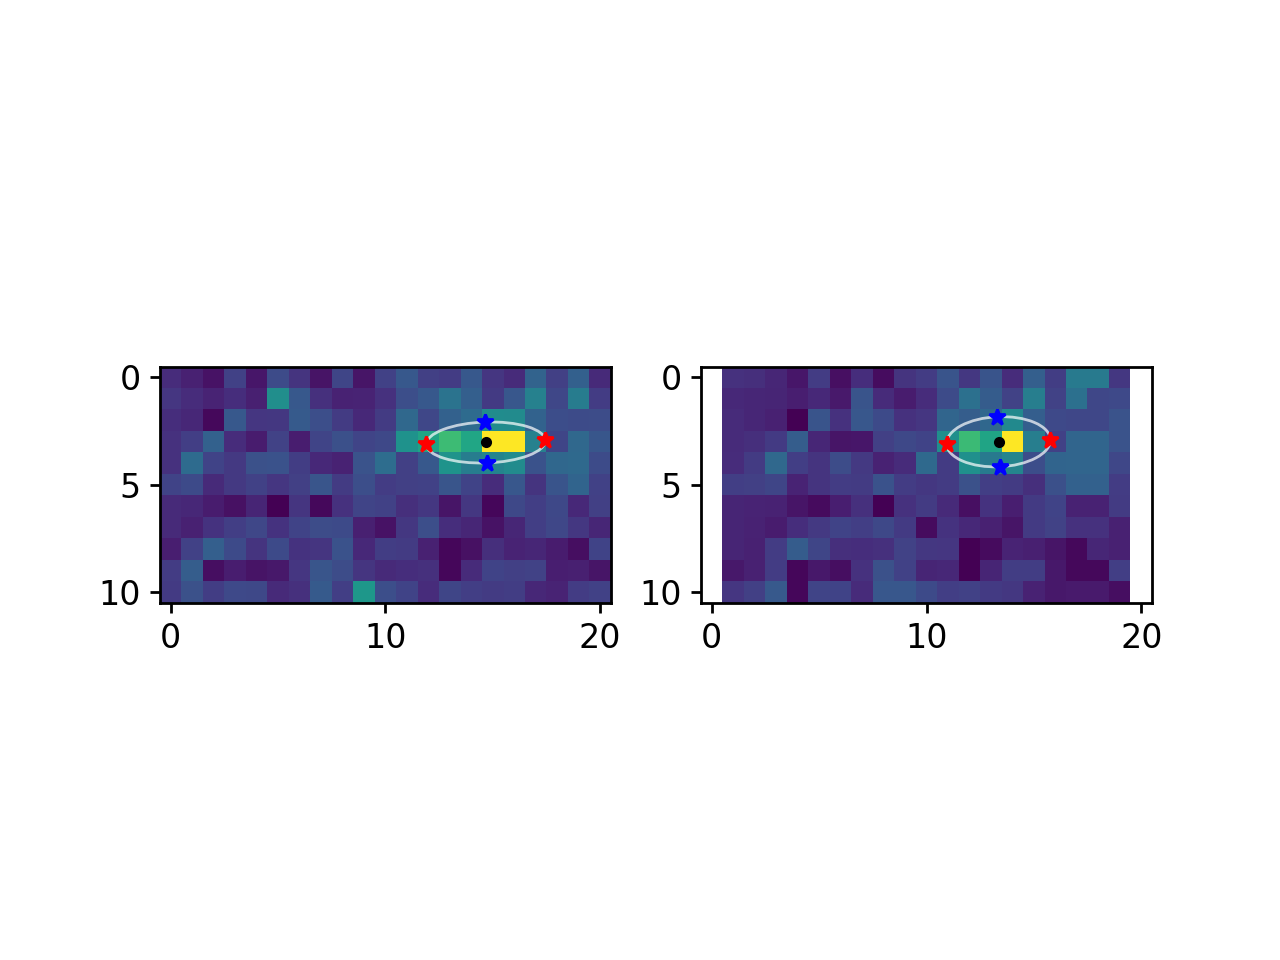

In [145]:
sigma_scale = 2.35

orig_params = {'x0': x0, 'y0': y0, 'sigma_x': sx, 'sigma_y': sy, 'theta': th}
warp_params = {'x0': x0_w, 'y0': y0_w, 'sigma_x': sx_w, 'sigma_y': sy_w, 'theta': th_w}


fig, axn = pl.subplots(1,2)
ax = axn[0]
ax.imshow(rfmap_o)
ell = Ellipse((orig_params['x0'], orig_params['y0']), 
                abs(orig_params['sigma_x'])*sigma_scale, 
                abs(orig_params['sigma_y'])*sigma_scale, 
                angle=np.rad2deg(orig_params['theta']))
ell.set_alpha(0.7)
ell.set_edgecolor('w')
ell.set_facecolor('none')
ell.set_linewidth(1)
ax.add_patch(ell) 

ax.plot(x0, y0, 'k.')
ax.plot(sx_linel[0], sx_linel[1], 'r*')
ax.plot(sx_line2[0], sx_line2[1], 'r*')
ax.plot(sy_line1[0], sy_line1[1], 'b*')
ax.plot(sy_line2[0], sy_line2[1], 'b*')

param_str = 'sx=%.2f, sy=%.2f @ (%.2f, %.2f)' % (sx_scaled, sy_scaled, x0_scaled, y0_scaled)
#ax.set_title(param_str, loc='left')

ax = axn[1]
ax.imshow(rfmap_w)
ell = Ellipse((warp_params['x0'], warp_params['y0']), 
                abs(warp_params['sigma_x'])*sigma_scale, 
                abs(warp_params['sigma_y'])*sigma_scale, 
                angle=np.rad2deg(warp_params['theta']))
ell.set_alpha(0.7)
ell.set_edgecolor('w')
ell.set_facecolor('none')
ell.set_linewidth(1)
ax.add_patch(ell) 
#param_str = 'sx=%.2f, sy=%.2f @ (%.2f, %.2f)' % (sx_w_scaled, sy_w_scaled, x0_w_scaled, y0_w_scaled)
#ax.set_title(param_str, loc='left')
ax.plot(x0_w, y0_w, 'k.')
ax.plot(sx_linel_w[0], sx_linel_w[1], 'r*')
ax.plot(sx_line2_w[0], sx_line2_w[1], 'r*')
ax.plot(sy_line1_w[0], sy_line1_w[1], 'b*')
ax.plot(sy_line2_w[0], sy_line2_w[1], 'b*')

<IPython.core.display.Javascript object>


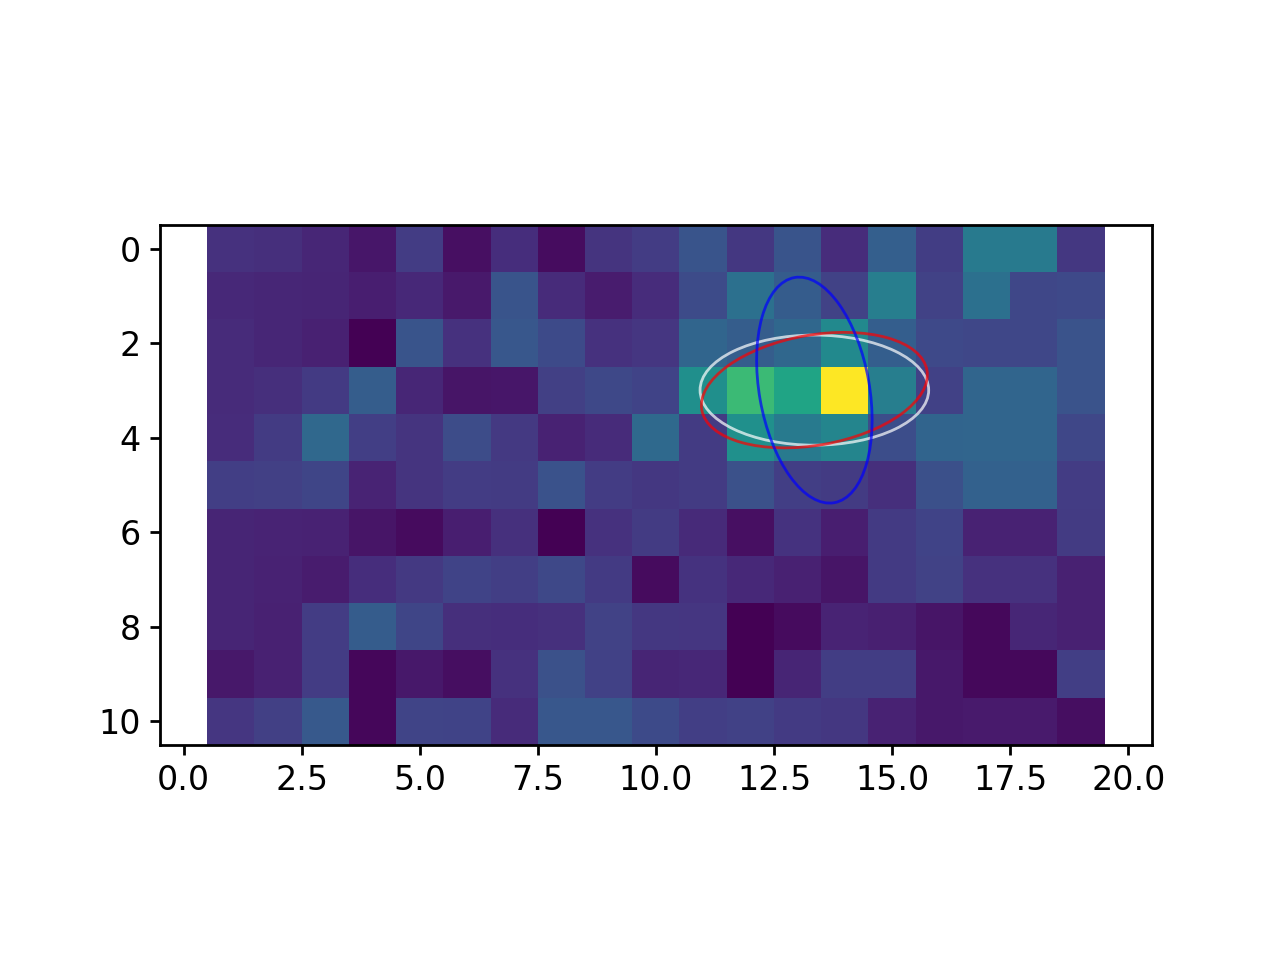

-2.4789486953628743
-2.4789486953628743


In [77]:
fig, ax = pl.subplots()
ax.imshow(rfmap_w)
ell = Ellipse((warp_params['x0'], warp_params['y0']), 
                abs(warp_params['sigma_x'])*sigma_scale, 
                abs(warp_params['sigma_y'])*sigma_scale, 
                angle=0)
ell.set_alpha(0.7)
ell.set_edgecolor('w')
ell.set_facecolor('none')
ell.set_linewidth(1)
ax.add_patch(ell) 


ell = Ellipse((warp_params['x0'], warp_params['y0']), 
                abs(warp_params['sigma_x'])*sigma_scale, 
                abs(warp_params['sigma_y'])*sigma_scale, 
                angle=-10) #np.rad2deg(warp_params['theta']))
ell.set_alpha(0.7)
ell.set_edgecolor('r')
ell.set_facecolor('none')
ell.set_linewidth(1)
ax.add_patch(ell) 
print(np.rad2deg(warp_params['theta']))


ell = Ellipse((warp_params['x0'], warp_params['y0']), 
                abs(warp_params['sigma_x'])*sigma_scale, 
                abs(warp_params['sigma_y'])*sigma_scale, 
                angle=-10+90) #np.rad2deg(warp_params['theta']))
ell.set_alpha(0.7)
ell.set_edgecolor('b')
ell.set_facecolor('none')
ell.set_linewidth(1)
ax.add_patch(ell) 
print(np.rad2deg(warp_params['theta']))

In [710]:
rdf.columns

Index([u'r2', u'fwhm_x', u'fwhm_y', u'theta', u'x0', u'y0', u'animalid',
       u'cell', u'datakey', u'experiment', u'fovnum', u'session',
       u'visual_area', u'std_x', u'std_y', u'fwhm_avg', u'std_avg', u'area',
       u'fx', u'fy', u'ratio_xy', u'theta_c', u'theta_Mm_deg', u'major_axis',
       u'minor_axis', u'anisotropy', u'theta_Mm_c', u'datakey_ix',
       u'aniso_index'],
      dtype='object')

<IPython.core.display.Javascript object>


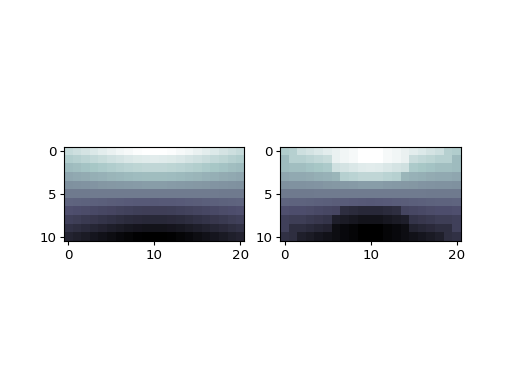

In [624]:
ny = nrows #resolution_ds[0]
nx = ncols #resolution_ds[1]
tst= np.array([sphr_y_ds[i, j] for i, j in zip(lut_i, lut_j)]).reshape(ny, nx)

fig, axn = pl.subplots(1, 2)
ax=axn[0]
ax.imshow(sphr_y_ds, cmap='bone') #, vmin=-30, vmax=30)

ax = axn[1]
ax.imshow(tst, cmap='bone') #, vmin=-30, vmax=30)


##### create LUT, then downsample?

In [523]:
lut_i, lut_j = deg_warp_lut(cart_x, cart_y, sph_x, sph_y)

In [526]:
luti_ds = cv2.resize(lut_i[pix_top_edge:pix_bottom_edge, pix_left_edge:pix_right_edge].astype(float), (ncols,nrows)).astype(int)
lutj_ds = cv2.resize(lut_j[pix_top_edge:pix_bottom_edge, pix_left_edge:pix_right_edge].astype(float), (ncols,nrows)).astype(int)

In [528]:
luti_ds

array([[178, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177, 177,
        177, 177, 177, 177, 177, 177, 177, 178],
       [178, 178, 178, 178, 178, 177, 177, 177, 177, 177, 177, 177, 177,
        177, 177, 177, 178, 178, 178, 178, 178],
       [178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178, 178,
        178, 178, 178, 178, 178, 178, 178, 178],
       [179, 179, 179, 179, 178, 178, 178, 178, 178, 178, 178, 178, 178,
        178, 178, 178, 178, 179, 179, 179, 179],
       [179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179,
        179, 179, 179, 179, 179, 179, 179, 179],
       [179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179, 179,
        179, 179, 179, 179, 179, 179, 179, 179],
       [180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180,
        180, 180, 180, 180, 180, 180, 180, 180],
       [180, 180, 180, 180, 181, 181, 181, 181, 181, 181, 181, 181, 181,
        181, 181, 181, 181, 180, 180, 180, 180],
       [181, 181, 181, 1

In [527]:
ny = nrows #resolution_ds[0]
nx = ncols #resolution_ds[1]
tst= np.array([sphr_y_ds[i, j] for i, j in zip(luti_ds, lutj_ds)]).reshape(ny, nx)

fig, axn = pl.subplots(1, 2)
ax=axn[0]
ax.imshow(sphr_y_ds, cmap='bone') #, vmin=-30, vmax=30)

ax = axn[1]
ax.imshow(tst, cmap='bone') #, vmin=-30, vmax=30)


IndexError: index 178 is out of bounds for axis 0 with size 11

<IPython.core.display.Javascript object>


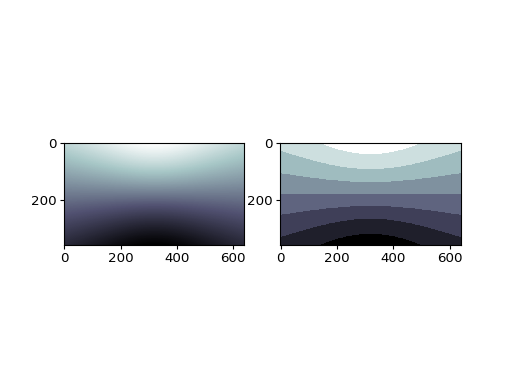

In [501]:
ny = resolution_ds[0]
nx = resolution_ds[1]
tst= np.array([sph_y[i, j] for i, j in zip(lut_i, lut_j)]).reshape(ny, nx)

fig, axn = pl.subplots(1, 2)
ax=axn[0]
ax.imshow(sph_y, cmap='bone') #, vmin=-30, vmax=30)

ax = axn[1]
ax.imshow(tst, cmap='bone') #, vmin=-30, vmax=30)



In [491]:
tst= np.array([np.rad2deg(sph_y)[i, j] for i, j in zip(lut_i, lut_j)]).reshape(ny, nx)
np.rad2deg(sph_y)==tst

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

In [530]:
1./pix_per_deg

0    0.186908
Name: pix_per_deg, dtype: float64

In [575]:
def distance(p0, p1):
    """
    calculate distance between two points, can be multi-dimensinal
    p0 and p1 should be a 1d array, with each element for each dimension
    """

    if not isinstance(p0, np.ndarray): p0 = np.array(p0)
    if not isinstance(p1, np.ndarray): p1 = np.array(p1)
    return np.sqrt(np.sum(np.square(p0 - p1).flatten()))


def warp_images(imgs, deg_coord_x, deg_coord_y, center_coor=(0, 0), deg_per_pixel=0.186908, is_luminance_correction=True):
    """
    warp a image stack into visual degree coordinate system
    parameters
    ----------
    imgs : ndarray
        should be 2d or 3d, if 3d, axis will be considered as frame x rows x width
    center_coor : list or tuple of two floats
        the visual degree coordinates of the center of the image (altitude, azimuth)
    deg_per_pixel : float or list/tuple of two floats
        size of original pixel in visual degrees, (altitude, azimuth), if float, assume
        sizes in both dimension are the same
    is_luminance_correction : bool
        if True, wrapped images will have mean intensity equal 0, and values will be
        scaled up to reach minimum equal -1. or maximum equal 1.
    returns
    -------
    imgs_wrapped : 3d array, np.float32
        wrapped images, each frame should have exact same size of down sampled monitor
        resolution. the region on the monitor not covered by the image will have value
        of np.nan. value range [-1., 1.]
    coord_alt_wrapped : 2d array, np.float32
        the altitude coordinates of all pixels in the wrapped images in visual degrees.
        should have the same shape as each frame in 'imgs_wrapped'.
    coord_azi_wrapped : 2d array, np.float32
        the azimuth coordinates of all pixels in the wrapped images in visual degrees.
        should have the same shape as each frame in 'imgs_wrapped'.
    imgs_dewrapped : 3d array, dtype same as imgs
        unwrapped images, same dimension as input image stack. the region of original
        image that was not got displayed (outside of the monitor) will have value of
        np.nan. value range [-1., 1.]
    coord_alt_dewrapped : 2d array, np.float32
        the altitude coordinates of all pixels in the dewrapped images in visual degrees.
        should have the same shape as each frame in 'imgs_dewrapped'.
    coord_azi_dewrapped : 2d array, np.float32
        the azimuth coordinates of all pixels in the dewrapped images in visual degrees.
        should have the same shape as each frame in 'imgs_dewrapped'.
    """

    try:
        deg_per_pixel_alt = abs(float(deg_per_pixel[0]))
        deg_per_pixel_azi = abs(float(deg_per_pixel[1]))
    except TypeError:
        deg_per_pixel_alt = deg_per_pixel_azi = deg_per_pixel

    if len(imgs.shape) == 2:
        imgs_raw = np.array([imgs])
        deg_coord_y2 = np.array([deg_coord_y])
        deg_coord_x2 = np.array([deg_coord_x])
    elif len(imgs.shape) == 3:
        imgs_raw = imgs
    else:
        raise ValueError('input "imgs" should be 2d or 3d array.')

    # generate raw image pixel coordinates in visual degrees
    alt_start = center_coor[0] + (imgs_raw.shape[1] / 2) * deg_per_pixel_alt
    alt_axis = alt_start - np.arange(imgs_raw.shape[1]) * deg_per_pixel_alt
    azi_start = center_coor[1] - (imgs_raw.shape[2] / 2) * deg_per_pixel_azi
    azi_axis = np.arange(imgs_raw.shape[2]) * deg_per_pixel_azi + azi_start
    # img_coord_azi, img_coord_alt = np.meshgrid(azi_axis, alt_axis)

    # initialize output array
    imgs_wrapped = np.zeros((imgs_raw.shape[0],
                             deg_coord_x.shape[0],
                             deg_coord_x.shape[1]), dtype=np.float32)
    imgs_wrapped[:] = np.nan
    
    coord_alt_wrapped = np.zeros((imgs_raw.shape[0],
                             deg_coord_x.shape[0],
                             deg_coord_x.shape[1]), dtype=np.float32)
    coord_alt_wrapped[:] = np.nan
    coord_azi_wrapped = np.zeros((imgs_raw.shape[0],
                             deg_coord_x.shape[0],
                             deg_coord_x.shape[1]), dtype=np.float32)
    coord_azi_wrapped[:] = np.nan
    
    # for cropping imgs_raw
    x_min = x_max = y_max = y_min = None

    # loop through every display (wrapped) pixel
    for ii in range(deg_coord_x.shape[0]):
        for jj in range(deg_coord_x.shape[1]):

            # the wrapped coordinate of current display pixel [alt, azi]
            coord_w = [deg_coord_y[ii, jj], deg_coord_x[ii, jj]]

            # if the wrapped coordinates of current display pixel is covered
            # by the raw image
            if alt_axis[0] >= coord_w[0] >= alt_axis[-1] and \
                                    azi_axis[0] <= coord_w[1] <= azi_axis[-1]:

                # get raw pixels arround the wrapped coordinates of current display pixel
                u = (alt_axis[0] - coord_w[0]) / deg_per_pixel_alt
                l = (coord_w[1] - azi_axis[0]) / deg_per_pixel_azi

                # for testing:
                # img_count[int(u), int(l)] += 1

                if (u == round(u) and l == round(l)):  # right hit on one raw pixel
                    imgs_wrapped[:, ii, jj] = imgs_raw[:, int(u), int(l)]

                    # for cropping
                    if x_min is None:
                        x_min = x_max = l
                        y_min = y_max = u
                    else:
                        x_min = min(x_min, l)
                        x_max = max(x_max, l)
                        y_min = min(y_min, u)
                        y_max = max(y_max, u)

                else:
                    u = int(u)
                    b = u + 1
                    l = int(l)
                    r = l + 1
                    w_ul = 1. / distance(coord_w, [alt_axis[u], azi_axis[l]])
                    w_bl = 1. / distance(coord_w, [alt_axis[b], azi_axis[l]])
                    w_ur = 1. / distance(coord_w, [alt_axis[u], azi_axis[r]])
                    w_br = 1. / distance(coord_w, [alt_axis[b], azi_axis[r]])

                    w_sum = w_ul + w_bl + w_ur + w_br

                    imgs_wrapped[:, ii, jj] = (imgs_raw[:, u, l] * w_ul +
                                               imgs_raw[:, b, l] * w_bl +
                                               imgs_raw[:, u, r] * w_ur +
                                               imgs_raw[:, b, r] * w_br) / w_sum
                    
                    coord_alt_wrapped[:, ii, jj] = (deg_coord_y2[:, u, l] * w_ul +
                                               deg_coord_y2[:, b, l] * w_bl +
                                               deg_coord_y2[:, u, r] * w_ur +
                                               deg_coord_y2[:, b, r] * w_br) / w_sum
                    coord_azi_wrapped[:, ii, jj] = (deg_coord_x2[:, u, l] * w_ul +
                                               deg_coord_x2[:, b, l] * w_bl +
                                               deg_coord_x2[:, u, r] * w_ur +
                                               deg_coord_x2[:, b, r] * w_br) / w_sum
                    # for cropping
                    if x_min is None:
                        x_min = l
                        x_max = l + 1
                        y_min = u
                        y_max = u + 1
                    else:
                        x_min = min(x_min, l)
                        x_max = max(x_max, l + 1)
                        y_min = min(y_min, u)
                        y_max = max(y_max, u + 1)

    if is_luminance_correction:
        for frame_ind in range(imgs_wrapped.shape[0]):
            curr_frame = imgs_wrapped[frame_ind]
            curr_mean = np.nanmean(curr_frame.flat)
            curr_frame = curr_frame - curr_mean
            curr_amp = np.max([np.nanmax(curr_frame.flat), abs(np.nanmin(curr_frame.flat))])
            curr_frame = curr_frame / curr_amp
            imgs_wrapped[frame_ind] = curr_frame

    # crop image
    alt_range = np.logical_and(np.arange(imgs_raw.shape[1]) >= y_min,
                               np.arange(imgs_raw.shape[1]) <= y_max)
    azi_range = np.logical_and(np.arange(imgs_raw.shape[2]) >= x_min,
                               np.arange(imgs_raw.shape[2]) <= x_max)

    imgs_dewrapped = imgs_raw[:, alt_range, :]
    imgs_dewrapped = imgs_dewrapped[:, :, azi_range]

    # get degree coordinats of dewrapped images
    deg_coord_alt_ax_dewrapped = alt_axis[alt_range]
    deg_coord_azi_ax_dewrapped = azi_axis[azi_range]
    deg_coord_azi_dewrapped, deg_coord_alt_dewrapped = np.meshgrid(deg_coord_azi_ax_dewrapped,
                                                                   deg_coord_alt_ax_dewrapped)
    deg_coord_alt_dewrapped = deg_coord_alt_dewrapped.astype(np.float32)
    deg_coord_azi_dewrapped = deg_coord_azi_dewrapped.astype(np.float32)

    return imgs_wrapped, coord_alt_wrapped, coord_azi_wrapped, imgs_dewrapped, deg_coord_alt_dewrapped, deg_coord_azi_dewrapped


In [609]:
# imgs_wrapped, alt_wrapped, azi_wrapped, imgs_dewrapped, deg_alt_dewrapped, deg_azi_dewrapped = warp_images(
#                                                                                  rfmap_orig, 
#                                                                                  np.rad2deg(sph_x),
#                                                                                  np.rad2deg(sph_y))


imgs_wrapped, alt_wrapped, azi_wrapped, imgs_dewrapped, deg_alt_dewrapped, deg_azi_dewrapped = warp_images(
                                                                                 rfmap_trim, 
                                                                                 np.rad2deg(sph_x),
                                                                                 np.rad2deg(sph_y))


((360, 640), (360, 640))


<IPython.core.display.Javascript object>


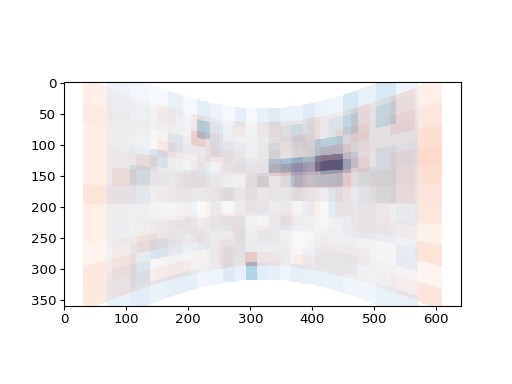

In [610]:
rfmap_warptest = imgs_wrapped[0]
print(rfmap_corrected.shape, rfmap_warptest.shape)

pl.figure()
pl.imshow(rfmap_warptest,cmap='Reds', alpha=0.5)
pl.imshow(rfmap_corrected, cmap='Blues', alpha=0.5)

<IPython.core.display.Javascript object>


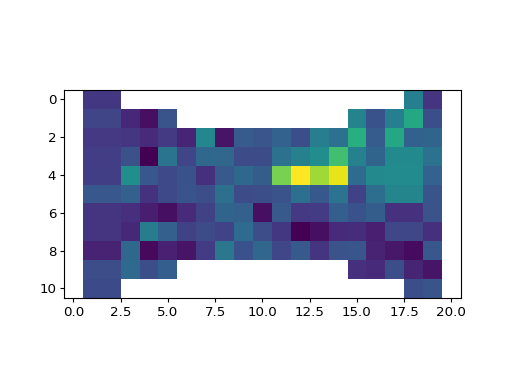

In [614]:
pl.figure()
pl.imshow(cv2.resize(rfmap_warptest, (nx, ny)))


<IPython.core.display.Javascript object>


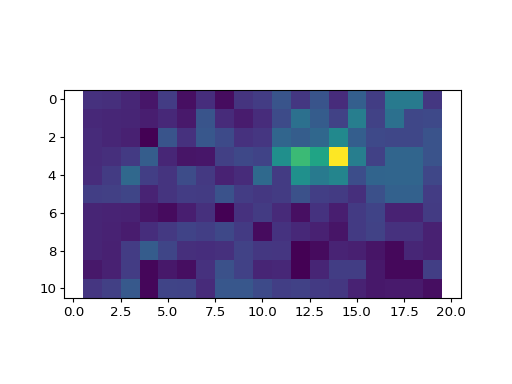

In [615]:
pl.figure()
pl.imshow(rfmap_w)


Orig: size (1.88, 1.69) @ (2.28, 4.86)
Corrected: size (1.98, 1.83) @ (2.52, 5.17)


<IPython.core.display.Javascript object>


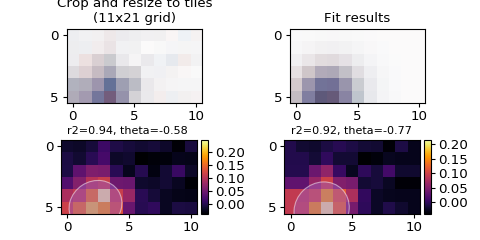

In [842]:
# PLOT.
# ------------
amp, x0, y0, sx, sy, th, off = fit_results_orig[rid]['fit_r']['popt']
print("Orig: size (%.2f, %.2f) @ (%.2f, %.2f)" % (sx, sy, x0, y0))
amp, x0, y0, sx, sy, th, off = fit_w[0]['popt']
print("Corrected: size (%.2f, %.2f) @ (%.2f, %.2f)" % (sx, sy, x0, y0))

# ------------
ny, nx = rfmap_w.shape
fig, axn = pl.subplots(2,2, figsize=(6,3))

ax = axn[0,0]
ax.imshow(rfmap_o, alpha=0.5, cmap='Reds')
ax.imshow(rfmap_w, alpha=0.5, cmap='Blues')
ax.set_title('Crop and resize to tiles\n(11x21 grid)')

ax=axn[0, 1]
ax.imshow(fit_r[1].reshape(ny, nx), alpha=0.5, cmap='Reds')
ax.imshow(fit_w[1].reshape(ny, nx), alpha=0.5, cmap='Blues')
ax.set_title('Fit results')

ax = axn[1, 0]
ax = fitrf.plot_rf_map(rfmap_o, cmap='magma', ax=ax)
ax = fitrf.plot_rf_ellipse(fit_r[0], ax=ax)

ax = axn[1, 1]
ax = fitrf.plot_rf_map(rfmap_w, cmap='magma', ax=ax)
ax = fitrf.plot_rf_ellipse(fit_w[0], ax=ax)

pl.subplots_adjust(wspace=0.5, hspace=0.5)

In [371]:
amp, x0, y0, sx, sy, th, off = fit_w[0]['popt']
print("(x, y)=(%.2f, %.2f) | sz=(%.2f, %.2f)" % (x0, y0, sx, sy))

(x, y)=(13.35, 3.00) | sz=(2.06, 0.99)


## Crop and resize?

<IPython.core.display.Javascript object>


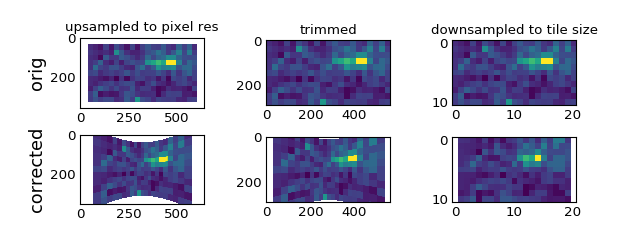

In [37]:
fig, axn= pl.subplots(2, 3, figsize=(8,3))

ax=axn[0,0]
ax.imshow(rfmap_orig)
ax.set_title('upsampled to pixel res')
ax.set_ylabel('orig')

ax=axn[0,1]
ax.imshow(rfmap_trim)
ax.set_title('trimmed')

ax=axn[0,2]
ax.imshow(rfmap_o)
ax.set_title('downsampled to tile size')


ax = axn[1,0]
ax.imshow(rfmap_corrected)
ax.set_ylabel('corrected')

ax=axn[1,1]
ax.imshow(rfmap_corr_trim)

ax=axn[1,2]
ax.imshow(rfmap_w)


for ax in axn.flat:
    ax.tick_params(which='both', axis='both', size=0)
pl.subplots_adjust(wspace=0.5, hspace=0.1)

In [164]:
reload(fitrf)

<module 'pipeline.python.retinotopy.fit_2d_rfs' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/retinotopy/fit_2d_rfs.py'>

In [38]:
fov = 'FOV%i_zoom2p0x' % fovnum
run_name = 'rfs'
post_stimulus_sec=0.5
sigma_scale=2.35
scale_sigma=True
rfdir, fit_desc = fitrf.create_rf_dir(animalid, session, fov, 
                                'combined_%s_static' % run_name, traceid=traceid,
                                response_type=response_type, fit_thr=fit_thr)
# Get data source
traceid_dir = rfdir.split('/receptive_fields/')[0]
data_fpath = os.path.join(traceid_dir, 'data_arrays', 'np_subtracted.npz')

In [39]:
raw_traces, labels, sdf, run_info = putils.load_dataset(data_fpath, 
                                            trace_type='corrected',
                                            add_offset=True, make_equal=False,
                                            create_new=False)        
#print("--- [%s|%s|%s|%s]: loaded traces (%s, for %s)." % (animalid, session, fov, run, trace_type, response_type))  


... loading saved data array (corrected).


In [40]:
# Get screen dims and fit params
fit_params = fitrf.get_fit_params(animalid, session, fov, run=run_name, traceid=traceid, 
                                    response_type=response_type, fit_thr=fit_thr,
                                    post_stimulus_sec=post_stimulus_sec, 
                                    sigma_scale=sigma_scale, scale_sigma=scale_sigma, 
                                    do_spherical_correction=True, ds_factor=3)


In [41]:
# Z-score or dff the traces:
trials_by_cond = fitrf.get_trials_by_cond(labels)
zscored_traces, zscores = fitrf.process_traces(raw_traces, labels, 
                                        response_type=fit_params['response_type'],
                                        nframes_post_onset=fit_params['nframes_post_onset']) 
avg_resp_by_cond = fitrf.group_trial_values_by_cond(zscores, trials_by_cond)

--- processed traces: dff


In [42]:
del raw_traces, zscored_traces

In [44]:
reload(fitrf)

<module 'pipeline.python.retinotopy.fit_2d_rfs' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/retinotopy/fit_2d_rfs.pyc'>

# Compare correced/uncorrected

In [824]:
def anisotropy_polarplot(rdf, metric='anisotropy', cmap='spring_r', ax=None, dpi=150):

    vmin=0; vmax=1;
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    iso_cmap = cm.ScalarMappable(norm=norm, cmap=cmap)
    
    if ax is None:
        fig, ax = pl.subplots(1, subplot_kw=dict(projection='polar'), figsize=(4,3), dpi=dpi)

    thetas = rdf['theta_Mm_c'].values #% np.pi
    ratios = rdf[metric].values
    ax.scatter(thetas, ratios, s=30, c=ratios, cmap=cmap, alpha=0.5) # c=thetas, cmap='hsv', alpha=0.7)

    ax.set_theta_zero_location("E")
    ax.set_theta_direction(1)
    # ax.set_theta_direction(1)
    ax.set_xticklabels(['0$^\circ$', '', '90$^\circ$', '', '', '', '-90$^\circ$', ''])
    ax.set_rlabel_position(135) #315)
    ax.set_xlabel('')
    ax.set_yticklabels(['', 0.4, '', 0.8])
    ax.set_ylabel(metric, fontsize=12)

    # Grid lines and such
    ax.spines['polar'].set_visible(False)
    pl.subplots_adjust(left=0.1, right=0.9, wspace=0.2, bottom=0.3, top=0.8, hspace=0.5)

    # Colorbar
    iso_cmap._A = []
    cbar_ax = ax.figure.add_axes([0.4, 0.15, 0.2, 0.03])
    cbar = ax.figure.colorbar(iso_cmap, cax=cbar_ax, orientation='horizontal', ticks=[0, 1])
    if metric == 'anisotropy':
        xlabel_min = 'Iso\n(%.1f)' % (vmin) 
        xlabel_max= 'Aniso\n(%.1f)' % (vmax) 
    else:             
        xlabel_min = 'H\n(%.1f)' % (vmin) if hue_param in ['angle', 'aniso_index'] else '%.2f' % vmin
        xlabel_max= 'V\n(%.1f)' % (vmax) if hue_param in ['angle', 'aniso_index'] else '%.2f' % vmax
    cbar.ax.set_xticklabels([xlabel_min, xlabel_max])  # horizontal colorbar
    cbar.ax.tick_params(which='both', size=0)

    return ax

In [825]:
def draw_rf_on_screen(rdf, hue_param='aniso_index', shape_str='ellipse', ax=None, dpi=150,
                      ellipse_scale=0.3, ellipse_alpha=0.2, ellipse_lw=1, ellipse_facecolor='none', 
                      axis_lw=2, axis_alpha=0.9, n_plot_rfs=-1, nplot_skip=1, 
                      centroid_size=5, centroid_alpha=0.3, vmin=-1, vmax=1):

    metric = 'anisotropy' if hue_param=='angle' else hue_param
    sat_param = 'aniso' if hue_param=='angle' else 'none'
    cmap = cm.cool if hue_param in ['angle', 'aniso_index'] else cm.spring_r

    #n_plot_rfs = -1
    #n_plot_skip = 1
    
    #axis_lw=2
    #axis_alpha=0.9
    #ellipse_lw=1
    #ellipse_alpha=0.2
    #ellipse_facecolor = 'none'
    borderpad=0

    centroid_size = centroid_size if shape_str=='centroid' else 2
    centroid_alpha = centroid_alpha if shape_str=='centroid' else 1.0
    ellipse_scale = ellipse_scale if shape_str=='ellipse' else 1.0

    vmin = vmin if metric=='aniso_index' else 0 
    vmax = vmax if metric=='aniso_index' else 1

    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    scalar_cmap = cm.ScalarMappable(norm=norm, cmap=cmap)

    if ax is None:
        fig, ax = pl.subplots(1, figsize=(5,4), dpi=dpi)
        
    ax.set_xlim([screenleft-borderpad, screenright+borderpad])
    ax.set_ylim([screenbottom-borderpad, screentop+borderpad])
    
    rf_indices = rdf.index.tolist()[0::n_plot_skip] #n_plot_rfs]
    for i in rf_indices:
                      
        # Current ROI's RF fit params
        x0, y0, std_x, std_y, theta, theta_c, aniso, aniso_v = rdf[[
            'x0', 'y0', 'std_x', 'std_y', 'theta', 'theta_Mm_c', metric, 'anisotropy']].loc[i]
        
        # Set color based on hue_param and cmap
        if hue_param == 'angle':
            theta_col = rfutils.assign_saturation(theta_c, aniso, cmap=cmap, min_v=min_ai, max_v=max_ai)
        elif hue_param == 'aniso_index':
            theta_col = scalar_cmap.to_rgba(aniso)
        elif hue_param == 'aniso':
            theta_col = scalar_cmap.to_rgba(aniso)
                      
        # PLOT
        if 'centroid' in shape_str:
            ax.plot(x0, y0, marker='o', color=theta_col, alpha=centroid_alpha, markersize=centroid_size)

        if 'ellipse' in shape_str:
            el = Ellipse((x0, y0), width=std_x*ellipse_scale, height=std_y*ellipse_scale, 
                         angle=theta, edgecolor=theta_col, facecolor=ellipse_facecolor, 
                         alpha=ellipse_alpha, lw=ellipse_lw)
            ax.add_artist(el)

        if 'major' in shape_str:
            M = rdf[['std_x', 'std_y']].loc[i].max()  
            m = rdf[['std_x', 'std_y']].loc[i].min()  
            xe = (M/2.) * np.cos(np.deg2rad(theta)) if std_x>std_y else -(M/2.) * np.sin(np.deg2rad(theta))
            ye = (M/2.) * np.sin(np.deg2rad(theta)) if std_x>std_y else (M/2.) * np.cos(np.deg2rad(theta))
            ax.plot([x0, x0+xe], [y0, y0+ye], color=theta_col, alpha=axis_alpha, lw=axis_lw)

        if 'minor' in shape_str:
            xe2 = (m/2.) * np.sin(np.deg2rad(theta)) if std_x>std_y else -(m/2.) * np.cos(np.deg2rad(180-theta))
            ye2 = (m/2.) * np.cos(np.deg2rad(theta)) if std_x>std_y else (m/2.) * np.sin(np.deg2rad(180-theta))
            ax.plot([x0, x0+xe2], [y0, y0+ye2], color=theta_col, alpha=axis_alpha, lw=axis_lw)
    ax.set_aspect('equal')

    # COLOR BAR
    scalar_cmap._A = []
    cbar_ax = ax.figure.add_axes([0.43, 0.1, 0.15, 0.05])
    cbar = ax.figure.colorbar(scalar_cmap, cax=cbar_ax, orientation='horizontal', ticks=[min_ai, max_ai])
    if hue_param == 'anisotropy':
        xlabel_min = 'Iso\n(%.1f)' % (vmin) 
        xlabel_max= 'Aniso\n(%.1f)' % (vmax) 
    else:             
        xlabel_min = 'H\n(%.1f)' % (vmin) if hue_param in ['angle', 'aniso_index'] else '%.2f' % vmin
        xlabel_max= 'V\n(%.1f)' % (vmax) if hue_param in ['angle', 'aniso_index'] else '%.2f' % vmax
                 
    cbar.ax.set_xticklabels([xlabel_min, xlabel_max])  # horizontal colorbar

    return ax

## plot RF orig v corrected

In [827]:
fitrf.get_fit_desc()
rfname = 'rfs10'
fit_results_orig, fit_params_orig = fitrf.load_fit_results(animalid, session, 'FOV%i_zoom2p0x' % fovnum,
                                        experiment=rfname, traceid=traceid,
                                        response_type=response_type, do_spherical_correction=False)

fit_results_warp, fit_params_warp = fitrf.load_fit_results(animalid, session, 'FOV%i_zoom2p0x' % fovnum,
                                        experiment=rfname, traceid=traceid,
                                        response_type=response_type, do_spherical_correction=True)
row_vals=fit_params_orig['row_vals']
col_vals = fit_params_orig['col_vals']

fitdf_orig = fitrf.rfits_to_df(fit_results_orig, fit_params=fit_params,
                               row_vals=row_vals, col_vals=col_vals, spherical=False)
fitdf_warp = fitrf.rfits_to_df(fit_results_warp, fit_params=fit_params,
                               row_vals=row_vals, col_vals=col_vals, spherical=True)
pass_rois_orig = [k for k, v in fit_results_orig.items() if v['r2']>0.5]
pass_rois_warp = [k for k, v in fit_results_warp.items() if v['r2']>0.5]

print("N fit (orig): %i" % len(pass_rois_orig))
print("N fit (warp): %i" % len(pass_rois_warp))


Screen res (ds=3x): [360, 640]
N fit (orig): 102
N fit (warp): 83


In [828]:
rdf_w = rfutils.update_rf_metrics(fitdf_warp[fitdf_warp['r2']>fit_thr])
print(rdf_w['aniso_index'].min(), rdf_w['aniso_index'].max())

rdf_o = rfutils.update_rf_metrics(fitdf_orig[fitdf_orig['r2']>fit_thr])
print(rdf_o['aniso_index'].min(), rdf_o['aniso_index'].max())

(-0.30330916610037456, 0.44610596880111886)
(-0.35955091247790344, 0.26746221741331599)


In [829]:
rdf_o.shape

(102, 21)

<IPython.core.display.Javascript object>


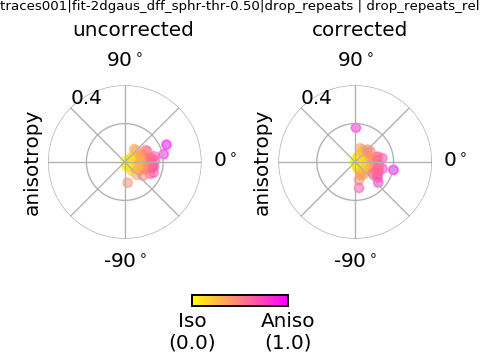

In [830]:
metric = 'anisotropy' #'ratio_xy'
cmap='spring_r'
# ---------------------------------------------------
fig, axn = pl.subplots(1, 2, subplot_kw=dict(projection='polar'), figsize=(4,3), dpi=dpi)
ax = axn[0]
ax = anisotropy_polarplot(rdf_o, metric=metric, cmap=cmap, ax=ax)
fig.text(0.15, 0.9, 'uncorrected', fontsize=12) #, loc='left')

ax = axn[1]
ax = anisotropy_polarplot(rdf_w, metric=metric, cmap=cmap, ax=ax)
fig.text(0.65, 0.9, 'corrected', fontsize=12) #, loc='left')

for ax in axn.flat:
    if 'anisotropy' in metric:
        ax.set_ylim([0, 1]) # 0.33 = major is double minor axis
    else:
        ax.set_ylim([0, 4.1])

pl.subplots_adjust(wspace=0.5, hspace=0.5, top=0.8)
putils.label_figure(fig, '%s | %s' % (data_id, filter_str))


<IPython.core.display.Javascript object>


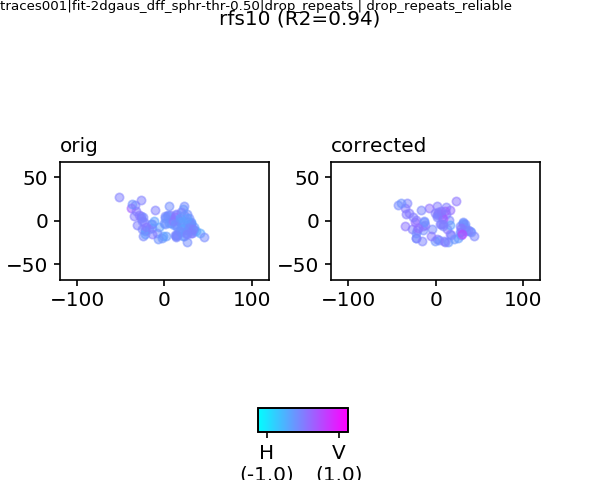

In [840]:
# filter_str='drop_repeats_reliable'
rfname = rdf['experiment'].unique()[0]
# ---------------------------------------------------
hue_param = 'aniso_index'
shape_str = 'centroid'
axis_lw=1
axis_alpha=1
centroid_alpha=0.5
ellipse_scale = 2.35

fig, axn = pl.subplots(1, 2, figsize=(5,4), dpi=dpi)
ax=axn[0]
ax = draw_rf_on_screen(rdf_o.dropna(), hue_param=hue_param, ax=ax,
                       shape_str=shape_str, ellipse_scale=ellipse_scale, 
                       axis_lw=axis_lw, axis_alpha=axis_alpha,
                       centroid_alpha=centroid_alpha)
ax.set_title('orig', loc='left')
#ax.set_ylim([-20, 20])
#ax.set_xlim([0, 50])

ax=axn[1]
ax = draw_rf_on_screen(rdf_w.dropna(), hue_param=hue_param, ax=ax,
                       shape_str=shape_str, ellipse_scale=ellipse_scale,
                       axis_lw=axis_lw, axis_alpha=axis_alpha,
                       centroid_alpha=centroid_alpha)


ax.set_title('corrected', loc='left')

pl.subplots_adjust(left=0.1, right=0.9, wspace=0.3, bottom=0.2)
pl.suptitle('%s (R2=%.2f)' % (rfname, r2))

putils.label_figure(fig, '%s | %s' % (data_id, filter_str))
#ax.set_ylim([-20, 20])
#ax.set_xlim([0, 50])

<IPython.core.display.Javascript object>


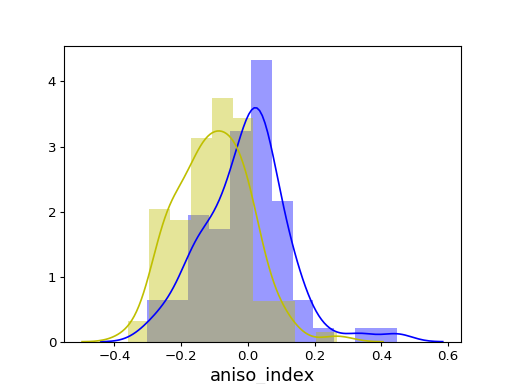

In [838]:
fig, ax = pl.subplots()
sns.distplot(rdf_w.dropna()['aniso_index'], ax=ax, color='b')
sns.distplot(rdf_o.dropna()['aniso_index'], ax=ax, color='y')

In [837]:
rdf_w.dropna()

,r2,fwhm_x,fwhm_y,theta,x0,y0,std_x,std_y,fwhm_avg,std_avg,...,fx,fy,ratio_xy,theta_c,theta_Mm_deg,major_axis,minor_axis,anisotropy,theta_Mm_c,aniso_index
19,0.543837,40.447594,27.443214,0.105051,28.268097,-13.000381,17.211742,11.677963,33.945404,14.444853,...,17.116857,1.804795,1.473865,0.105051,6.019006,17.211742,11.677963,0.191548,0.105051,-0.151378
21,0.662921,50.033711,16.314784,6.080204,31.238786,-2.735138,21.290941,6.942461,33.174247,14.116701,...,20.853836,4.292048,3.066771,-0.202981,348.370026,21.290941,6.942461,0.508209,-0.202981,-0.303309
25,0.762045,38.479961,27.396576,0.239994,33.712619,-3.518164,16.374451,11.658118,32.938269,14.016285,...,15.905151,3.892151,1.404554,0.239994,13.750631,16.374451,11.658118,0.168245,0.239994,-0.088262
26,0.757162,39.943769,27.649312,6.205361,33.464170,-6.682830,16.997349,11.765665,33.796541,14.381507,...,16.945902,1.321467,1.444657,-0.077824,355.541011,16.997349,11.765665,0.181889,-0.077824,-0.153607
28,0.743845,37.628118,23.799590,6.171125,39.870999,-11.940586,16.011965,10.127485,30.713854,13.069725,...,15.911535,1.790557,1.581041,-0.112061,353.579402,16.011965,10.127485,0.225119,-0.112061,-0.174770
34,0.598386,33.914456,26.036680,0.168666,30.844823,-1.439567,14.431683,11.079438,29.975568,12.755561,...,14.226891,2.422611,1.302565,0.168666,9.663855,14.431683,11.079438,0.131403,0.168666,-0.087287
36,0.615404,35.411783,25.194720,2.867747,28.150915,-5.842226,15.068844,10.721157,30.303251,12.895001,...,14.507350,4.075151,1.405524,-0.273845,164.309812,15.068844,10.721157,0.168580,-0.273845,-0.077400
39,0.652279,30.821346,23.285498,0.061675,31.550375,-3.983594,13.115467,9.908723,27.053422,11.512095,...,13.090530,0.808387,1.323628,0.061675,3.533733,13.115467,9.908723,0.139277,0.061675,-0.122108
46,0.869498,36.595352,27.827481,5.242513,23.487774,22.262786,15.572490,11.841481,32.211417,13.706986,...,7.874075,13.435081,1.315080,-1.040673,300.373852,15.572490,11.841481,0.136099,-1.040673,0.098738
47,0.625633,28.921344,42.477254,5.947005,16.733666,12.162132,12.306955,18.075427,35.699299,15.191191,...,17.063591,5.962795,0.680867,-0.336181,70.738262,18.075427,12.306955,0.189862,1.234616,0.168606


In [512]:
rdf[rdf['cell']==rid]

,r2,fwhm_x,fwhm_y,theta,x0,y0,animalid,cell,datakey,experiment,...,fy,ratio_xy,theta_c,theta_Mm_deg,major_axis,minor_axis,anisotropy,theta_Mm_c,aniso_index,datakey_ix
1576,0.588694,27.720947,9.519791,6.24957,23.379651,-9.85265,JC097,32,20190617_JC097_fov1,rfs,...,0.396455,2.911928,-0.033615,358.073992,11.796148,4.050975,0.488743,-0.033615,-0.455891,6


In [486]:
from pipeline.python.classifications import experiment_classes as utils

In [487]:
reload(utils)
reload(fitrf)

<module 'pipeline.python.retinotopy.fit_2d_rfs' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/retinotopy/fit_2d_rfs.py'>

In [514]:
exp = utils.ReceptiveFields('rfs', animalid, session, 'FOV%i_zoom2p0x' % fovnum)


In [515]:
estats = exp.get_stats(do_spherical_correction=True)

... (combined_rfs_static) getting stats, reload_data=False
... loading existing stats
... (stats) loading receptive field fits
... loaded fits (combined_rfs_static, fit-2dgaus_dff_sphr)
... fit results (79 of 235 attempted fits with R2 > 0.50)
Screen res (ds=3x): [360, 640]
... got stats (n fit: 79, n attempted: 235


In [490]:
rid = 32 #68 #32 #61 #rid = 61
rd = estats.gdf.get_group(rid)[['config', 'trial', 'dff']]
rd.shape

(2574, 3)

In [516]:
estats.fits.loc[rid]

r2          0.521644
sigma_x    28.515445
sigma_y    14.154651
theta       6.239919
x0         21.688012
y0        -12.417869
Name: 32, dtype: float64

In [417]:
from pipeline.python.classifications import evaluate_receptivefield_fits as evalrf
reload(evalrf)

<module 'pipeline.python.classifications.evaluate_receptivefield_fits' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/evaluate_receptivefield_fits.py'>

In [517]:
glist = [evalrf.group_configs(grp, 'dff') for cfg, grp in rd.groupby(['config'])]
respdf = pd.concat(glist, axis=1)
print(respdf.shape)


(12, 231)


In [518]:
respdf.head()

,config001,config002,config003,config004,config005,config006,config007,config008,config009,config010,...,config222,config223,config224,config225,config226,config227,config228,config229,config230,config231
0,-0.015412,-0.001813,0.007561,0.006968,-0.010414,0.000766,-0.024754,-0.037387,-0.093539,-0.007023,...,0.020766,-0.013180,-0.021252,-0.007543,-0.004120,0.000564,0.019809,0.014277,-0.016982,0.008597
1,-0.003876,0.003444,-0.043217,-0.017535,-0.011413,0.003352,0.023020,-0.014223,-0.027898,-0.005897,...,0.013950,0.062288,-0.003855,0.012815,-0.004043,-0.024837,-0.011586,0.017929,-0.020015,0.012783
2,-0.000544,-0.029405,0.018211,-0.012233,0.039905,0.001056,0.000370,0.011295,-0.006046,-0.004927,...,-0.006058,-0.006832,0.007083,0.051133,-0.022662,-0.024644,-0.017811,-0.021310,-0.008575,0.005199
3,-0.032531,-0.005721,0.027854,-0.014292,0.007262,-0.005439,-0.019388,0.014399,-0.002786,-0.017443,...,-0.011971,0.035122,-0.022780,0.021450,-0.029427,0.006503,0.020647,-0.012858,-0.016343,0.019250
4,-0.014596,-0.004584,-0.031206,0.012826,0.004425,0.002547,-0.044117,-0.030944,-0.016876,0.002316,...,0.002426,0.005678,0.018067,-0.026249,-0.016962,0.007053,0.008929,0.018891,-0.013495,-0.003045


In [420]:
respdf.mean(axis=0).shape

(231,)

In [519]:
n_resamples=10
n_boot_iters=500
nx = len(col_vals)
ny = len(row_vals)

bootdf = pd.concat([respdf.sample(n_resamples, replace=True).mean(axis=0)
                    for ni in np.arange(n_boot_iters)], axis=1)
bootdf.shape

(231, 500)

In [520]:


bootdf_r = bootdf.apply(fitrf.reshape_array_for_nynx, args=(nx, ny))


<IPython.core.display.Javascript object>


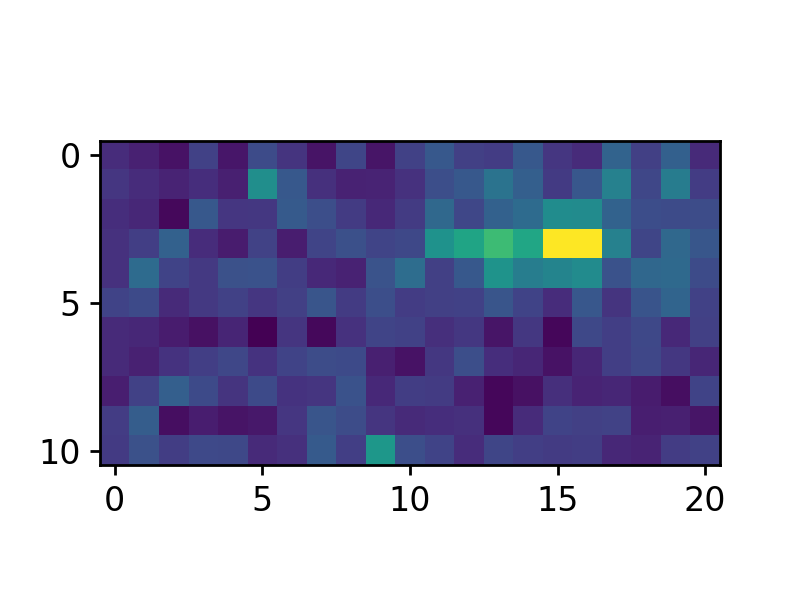

In [521]:
rvec = respdf.mean(axis=0)
rmap = fitrf.get_rf_map(rvec, len(row_vals), len(col_vals))
pl.figure(figsize=(4,3))
pl.imshow(rmap.T)

In [494]:
reload(fitrf)

<module 'pipeline.python.retinotopy.fit_2d_rfs' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/retinotopy/fit_2d_rfs.pyc'>

In [560]:
xres=5
yres=5
sigma_scale=2.35
min_sigma=2
max_sigma=50
do_spherical_correction=True

xres=1 if do_spherical_correction else float(np.unique(np.diff(row_vals)))
yres=1 if do_spherical_correction else float(np.unique(np.diff(col_vals)))
sigma_scale=1 if do_spherical_correction else 2.35
sigma_scale=1 if do_spherical_correction else 2.35

bparams = []; #x0=[]; y0=[];
for ii in bootdf_r.columns:
    response_vector = bootdf_r[ii].values
    rfmap = fitrf.get_rf_map(response_vector, len(col_vals), len(row_vals))
    fitr, fit_y = fitrf.do_2d_fit(rfmap, nx=len(col_vals), ny=len(row_vals))
    if fitr['success']:
        amp_f, x0_f, y0_f, sigx_f, sigy_f, theta_f, offset_f = fitr['popt']
        x0_f, y0_f, sigx_f, sigy_f = fitrf.get_scaled_sigmas(grid_points, sphr_values,
                                             x0_f, y0_f,
                                             sigx_f, sigy_f, theta_f,
                                             convert=True)
        #print(x0_f, y0_f, sigx_f, sigy_f)
        fitr['popt'] = (amp_f, x0_f, y0_f, sigx_f, sigy_f, theta_f, offset_f)
        if any(s < min_sigma for s in [abs(sigx_f)*xres*sigma_scale, abs(sigy_f)*yres*sigma_scale])\
            or any(s > max_sigma for s in [abs(sigx_f)*xres*sigma_scale, abs(sigy_f)*yres*sigma_scale]):
            fitr['success'] = False

    # if the fit for current bootstrap sample is good, add it to dataframe of bootstrapped rf params
    if fitr['success']:
        #amp_f, x0_f, y0_f, sigx_f, sigy_f, theta_f, offset_f = fitr['popt']
        curr_fit_results = list(fitr['popt'])
        curr_fit_results.append(fitr['r2'])
        bparams.append(tuple(curr_fit_results)) #(fitr['popt'])


bparams = np.array(bparams)   
bootdata = pd.DataFrame(data=bparams, columns=['amp', 'x0', 'y0', 'sigma_x', 'sigma_y', 'theta', 'offset', 'r2'])
bootdata['cell'] = [rid for _ in range(bparams.shape[0])]


In [531]:
bootdata.mean(axis=0)

amp         0.089829
x0         29.036930
y0        -11.557381
sigma_x    11.778136
sigma_y     4.785915
theta       0.027504
offset     -0.001690
r2          0.451971
cell       32.000000
dtype: float64

In [532]:
estats.fits.loc[rid]

r2          0.521644
sigma_x    28.515445
sigma_y    14.154651
theta       6.239919
x0         21.688012
y0        -12.417869
Name: 32, dtype: float64

In [565]:
sigma_scale=2.35

bootdata_c=bootdata.copy()
# dont need to convert if do_spherical 
#bootdata_c = fitrf.convert_fit_to_coords_spherical(bdf, fit_params_warp,
#                                                 spherical=True)
# bootdata['x0'] = xx
# bootdata['y0'] = yy
bootdata_c['sigma_x'] = bootdata['sigma_x'] * sigma_scale
bootdata_c['sigma_y'] = bootdata['sigma_y'] * sigma_scale
theta_vs = bootdata['theta'].values.copy()
bootdata_c['theta'] = theta_vs % (2*np.pi)
bootdata_c['cell'] = rid


In [567]:
bdf = bootdata_c[bootdata_c['r2']>0.5].copy()
print(bdf['sigma_x'].min(), bdf['sigma_x'].max())
print(bdf['sigma_y'].min(), bdf['sigma_y'].max())


(6.835703204377419, 36.003170494747636)
(5.549692775373899, 19.92021018756935)


In [572]:
estats.fits.loc[rid]

r2          0.521644
sigma_x    28.515445
sigma_y    14.154651
theta       6.239919
x0         21.688012
y0        -12.417869
Name: 32, dtype: float64

In [592]:
bootdata_c = bootdata_c.dropna()


In [593]:
# Calculate confidence intervals
ci=.95
bootcis = evalrf.get_cis_for_params(bootdata_c, ci=ci)

In [594]:
bootcis

,amp_lower,amp_upper,offset_lower,offset_upper,r2_lower,r2_upper,sigma_x_lower,sigma_x_upper,sigma_y_lower,sigma_y_upper,theta_lower,theta_upper,x0_lower,x0_upper,y0_lower,y0_upper
32,0.041157,0.201512,-0.00329,0.000064,0.290366,0.600867,8.017186,39.974249,6.751149,19.426895,0.009826,6.273371,21.62773,34.316397,-13.163152,-9.858292


In [595]:
roi_list=[rid]

params = [p for p in estats.fits.columns.tolist() if p!='r2']
pass_cis = pd.concat([pd.DataFrame(
        [bootcis['%s_lower' % p][ri] <= estats.fits[p][ri] <= bootcis['%s_upper' % p][ri] \
        for p in params], columns=[ri], index=params) \
            for ri in roi_list], axis=1).T
pass_cis

,sigma_x,sigma_y,theta,x0,y0
32,True,True,True,True,True


In [600]:
reload(evalrf)


<module 'pipeline.python.classifications.evaluate_receptivefield_fits' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/evaluate_receptivefield_fits.py'>

In [601]:
fovcoords = exp.get_roi_coordinates()

... loading roi coords


In [602]:
eval_results, eval_params = evalrf.load_eval_results(animalid, session, 'FOV%i_zoom2p0x' % fovnum, 
                                                     experiment='rfs', do_spherical_correction=True)


Checking to load: fit-2dgaus_dff_sphr


In [603]:
meas_df = fitrf.rfits_to_df(fit_results_warp, spherical=True, 
                            fit_params=fit_params,
                            row_vals=fit_params_warp['row_vals'], 
                            col_vals=fit_params_warp['col_vals'],
                            scale_sigma=fit_params_warp['scale_sigma'], 
                            sigma_scale=fit_params_warp['sigma_scale'])
meas_df = meas_df[meas_df['r2']>fit_params_warp['fit_thr']]

#%% Fit linear regression for brain coords vs VF coords 
posdf = pd.concat([meas_df[['x0', 'y0']].copy(), 
                   fovcoords['roi_positions'].copy()], axis=1) 
posdf = posdf.rename(columns={'x0': 'xpos_rf', 'y0': 'ypos_rf',
                              'ml_pos': 'xpos_fov', 'ap_pos': 'ypos_fov'})



Screen res (ds=3x): [360, 640]


In [604]:
meas_df.loc[rid]

r2          0.521644
sigma_x    28.515445
sigma_y    14.154651
theta       6.239919
x0         21.688012
y0        -12.417869
Name: 32, dtype: float64

In [605]:
bootdata = eval_results['data']
bootcis = eval_results['cis']
fit_rois = [int(k) for k, g in bootdata.groupby(['cell'])]    
pass_rois = eval_results['pass_cis'].index.tolist()
pass_cis = eval_results['pass_cis'].copy()
reliable_rois = evalrf.get_reliable_fits(eval_results['pass_cis'], pass_criterion='any')
#print('%i reliable of %i fit (thr>.5)' % (len(reliable_rois), len(pass_rois)))

#% # Plot bootstrapped param CIs + regression CI
#xaxis_lim = max([xlim, ylim])
reg_results = {}
#filter_str = '_filter-weird' if filter_weird else ''



<IPython.core.display.Javascript object>


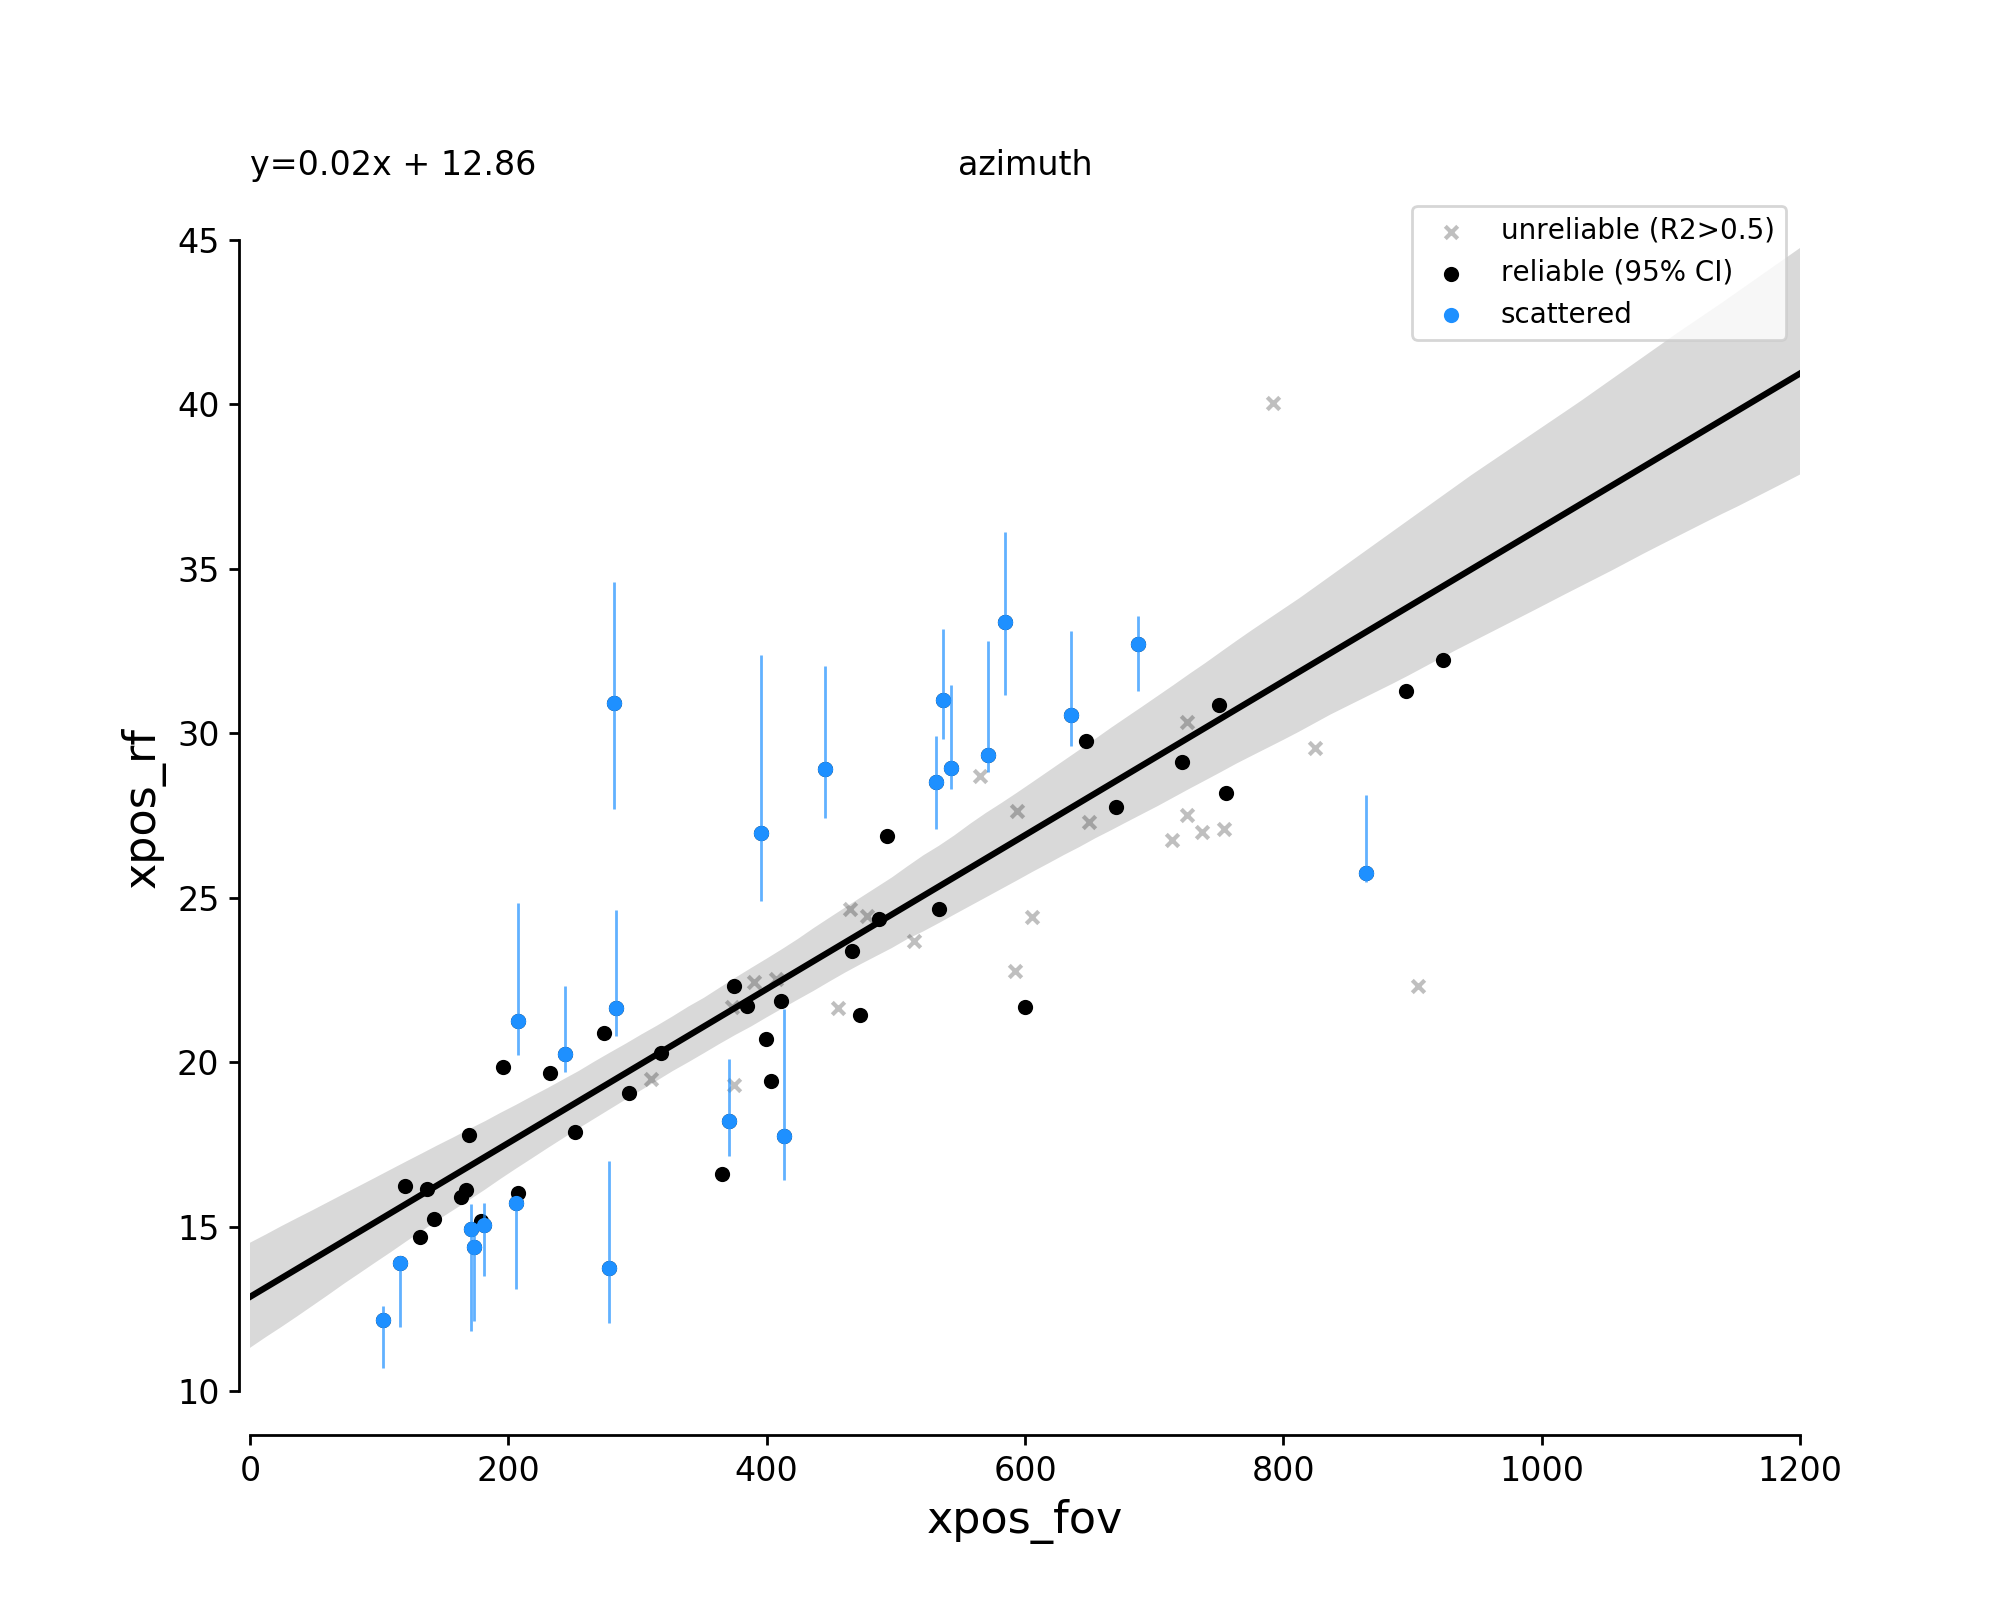

[azimuth] N deviants: 23 (of 57 reliable fits) | 0 bad fits


In [606]:
fig, regr, regci, rel_c, devs, bads = evalrf.do_regr_on_fov_cis(
                                        bootdata, bootcis, posdf, pass_cis, cond='azimuth')

In [607]:
marker_size=5
fill_marker=True
xaxis_lim=None

cond='elevation'

axname = 'xpos' if cond=='azimuth' else 'ypos'
parname = 'x0' if cond=='azimuth' else 'y0'

pass_criterion = parname
reliable_rois = evalrf.get_reliable_fits(pass_cis, single=True,
                                                pass_criterion=pass_criterion)
print("[%s] %i reliable" % (cond, len(reliable_rois)))
      


[elevation] 69 reliable


In [608]:

fig, ax = pl.subplots(figsize=(10,8)); ax.set_title(cond);
ax.set_ylabel('RF position (rel. deg.)')
ax.set_xlabel('FOV position (um)')
if xaxis_lim is not None:
    ax.set_xlim([0, xaxis_lim])
else:
    ax.set_xlim([0, 1200])
       

# 1. Identify which cells fail bootstrap fits - do not include in fit.
fail_rois = [r for r in posdf.index.tolist() if r not in reliable_rois] #roi_list]
fail_df = posdf.loc[fail_rois].copy()
sns.regplot('%s_fov' % axname, '%s_rf' % axname, data=fail_df, ax=ax, 
            label='unreliable (R2>0.5)', color='gray', marker='x', fit_reg=False,
            scatter_kws=dict(s=marker_size, alpha=0.5))
jau7                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         I                                                                                         
# 2a. Linear regression, include cells with reliable fits (R2 + 95% CI) 
scatter_kws = dict(s=marker_size, alpha=1.0, facecolors='k')
if not fill_marker:
    scatter_kws.update({'facecolors':'none', 'edgecolors':'k'})
ax, plotter = evalrf.regplot('%s_fov' % axname, '%s_rf' % axname,  ax=ax,
                      data=posdf.loc[reliable_rois], ci=ci*100, color='k', marker=marker, 
                      scatter_kws=scatter_kws, label='reliable (%i%% CI)' % int(ci*100)) 



# 2b. Get CIs from linear fit (fit w/ reliable rois only)
grid, yhat, err_bands = plotter.fit_regression(grid=plotter.x)
e1 = err_bands[0, :] # err_bands[0, np.argsort(xvals)] <- sort by xpos to plot
e2 = err_bands[1, :] #err_bands[1, np.argsort(xvals)]
regr_cis = np.array([(ex, ey) for ex, ey in zip(e1, e2)])


# Get mean and upper/lower CI bounds of bootstrapped distn for each cell
boot_rois = [k for k, g in bootdata.groupby(['cell'])] 
roi_ixs = [boot_rois.index(ri) for ri in reliable_rois]

#boot_meds = np.array([g[parname].mean() for k, g in bootdata.groupby(['cell'])])
#x0_lower = bootcis['%s_lower' % parname][boot_rois] #[roi_list]
#x0_upper = bootcis['%s_upper' % parname][boot_rois] #[roi_list]

fov_pos = posdf['%s_fov' % axname][reliable_rois].values
rf_pos = posdf['%s_rf' % axname][reliable_rois].values 
fitv, regr = evalrf.fit_linear_regr(fov_pos, rf_pos, return_regr=True, model='ridge')
regr_info = {'regr': regr, 'fitv': fitv, 'xv': fov_pos, 'yv': rf_pos}

#ax.plot(fov_pos, fitv, 'r:')
eq_str = 'y=%.2fx + %.2f' % (regr.coef_[0], regr.intercept_[0])
ax.set_title(eq_str, loc='left', fontsize=12)

#%
boot_meds = np.array([g[parname].mean() for k, g in bootdata[bootdata['cell'].isin(reliable_rois)].groupby(['cell'])])
bootc = [(lo, up) for lo, up in zip(bootcis['%s_lower' % parname][reliable_rois].values, 
                                     bootcis['%s_upper' % parname][reliable_rois].values)]

# Get YERR for plotting, (2, N), where 1st row=lower errors, 2nd row=upper errors
boot_errs = np.array(zip(boot_meds - bootcis['%s_lower' % parname].loc[reliable_rois].values, 
                        bootcis['%s_upper' % parname].loc[reliable_rois].values - boot_meds)).T


SyntaxError: invalid syntax (<ipython-input-608-c0e8c0823748>, line 17)